In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
os.chdir(".")
# from parc.data import EnergeticMatDataPipeLine as EmData
from parc import misc, metrics, model,visualization
from parc.model import model_burgers
from skimage.measure import block_reduce



2023-11-19 14:07:55.043984: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-19 14:07:55.742963: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data pipeline

In [2]:
import time
import os
import numpy as np
import skimage
from skimage.measure import block_reduce


Re_list = [15,20,30,40,60,80,100,120,140,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000]

def clip_raw_data():
    data_whole = []

    for Re in Re_list:
        data_file_name = 'Re_' + str(int(Re)) + '.npy'
#         print(data_file_name)
        file_path = './ns_data/' + data_file_name                
        if os.path.exists(file_path):
            raw_data = np.float32(np.load(file_path))
            raw_data = np.expand_dims(raw_data, axis = 0)
#             raw_data = skimage.measure.block_reduce(raw_data[:,:,:,:], (1,2,2,1),np.max)
            data_shape = raw_data.shape
#             print(data_shape)
#             norm_r = Re/15000
#             r_img = norm_r*np.ones(shape = (data_shape[0],data_shape[1],data_shape[2],1))
#             raw_data = np.concatenate([r_img,raw_data], axis = -1)
#             print(raw_data.shape)
#             print(r_img.shape)
# #                     print(r_img.shape)

#             vel_seq_case = [np.concatenate(
#                 [np.concatenate([np.expand_dims(raw_data[(j + k), :, :, :],axis = 0),r_img],axis = -1)
#                 for k in range(sequence_length)], axis=-1)
#                 for j in range (num_time_steps-sequence_length+1)] 
            data_whole.extend(raw_data)

    data_whole = np.concatenate([data_whole], axis=0)

    return data_whole

seq_clipped = clip_raw_data()



In [3]:
# Normalization
def data_normalization(input_data,no_of_channel):
    norm_data = np.zeros(input_data.shape)
#     norm_data[:,:,:,0:1] = input_data[:,:,:,0:1]
    min_val = []
    max_val = []
    for i in range(no_of_channel):
        norm_data[:,:,:,(i)::no_of_channel] = ((input_data[:,:,:,(i)::no_of_channel] - np.amin(input_data[:,:,:,(i)::no_of_channel])) / (np.amax(input_data[:,:,:,(i)::no_of_channel]) - np.amin(input_data[:,:,:,(i)::no_of_channel])) + 1E-9)
        min_val.append(np.amin(input_data[:,:,:,(i)::no_of_channel]))
        max_val.append(np.amax(input_data[:,:,:,(i)::no_of_channel]))
    return norm_data, min_val, max_val

In [4]:
seq_clipped.shape
seq_norm = data_normalization(seq_clipped, 3)

In [31]:
print(seq_norm[1], seq_norm[2])


[-2.757973, -2.6737006, -255955.38] [4.0362315, 2.584277, 109451.57]


In [6]:
Re_list = [15,20,30,40,60,80,100,120,140,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000]
train_list = [30,40,80,100,150,200,250,300,400,450,500,600,650,700,800,850,900,950]
test_list = [20,60,140,350,550,750,1000]
idx = 0
train_idx =[]
test_idx =[]
for Re in Re_list:
    if Re in train_list:
        train_idx.append(idx)
    elif Re in test_list:
        test_idx.append(idx)
    idx += 1

In [7]:
print(test_idx)

[1, 4, 8, 13, 17, 21, 26]


In [8]:
train_seq = [seq_norm_train[idx:idx+1,:,:,:] for idx in train_idx]
test_seq = [seq_norm_train[idx:idx+1,:,:,:] for idx in test_idx]

In [9]:
train_seq = np.concatenate(train_seq, axis = 0)
test_seq = np.concatenate(test_seq, axis = 0)
print(test_seq.shape)

(7, 128, 256, 117)


In [10]:
print(train_seq.shape)

(18, 128, 256, 117)


In [11]:
def create_train_data(seq, no_of_fields, sequence_length = 2):
    shape = seq.shape
    num_time_steps = np.int32((shape[-1]-1)/3)
    vel_seq_whole = []
#     constant_whole = []
    for i in range(shape[0]):
#         constant = seq[i:i+1,:,:,0:1]
        for j in range(num_time_steps-sequence_length+1):
            vel_seq_case = np.expand_dims(seq[i, :, :, (j*no_of_fields):(j*no_of_fields+sequence_length*no_of_fields)],axis = 0)
#             vel_seq_case = np.concatenate([constant,vel_seq_case],axis = -1)
            vel_seq_whole.extend(vel_seq_case)
    vel_seq_whole = np.concatenate([vel_seq_whole], axis=0)
    return vel_seq_whole

train_data = create_train_data(train_seq, no_of_fields = 3, sequence_length = 11)

In [12]:
from tensorflow import keras
from tensorflow.keras import  layers, regularizers
from keras.layers import *
import tensorflow as tf
from parc import layer

from tensorflow.keras.layers import Concatenate, Input
from tensorflow.keras.models import Model

def differentiator_ns():
    # Model initiation
    feature_extraction = layer.feature_extraction_unet(input_shape = (128,256), n_out_features = 64, n_base_features = 64, n_channel = 3)
    
    advection = [layer.Advection() for _ in range(2)]
    diffusion = [layer.Diffusion() for _ in range(2)]
    velocity_mapping_and_recon = layer.mapping_and_recon_cnn(input_shape = (128,256), n_base_features = 64, n_mask_channel=4, output_channel=2)

    # Main computation graph
    velocity_field = Input(shape=(128,256, 3), dtype = tf.float32)

    # Reaction term
    dynamic_feature = feature_extraction(velocity_field)

    # u
    advec_u = advection[0](velocity_field[:, :, :, 0:1], velocity_field[:, :, :, :2])
    diffusion_u = diffusion[0](velocity_field[:, :, :, 0:1])
    
    # v
    advec_v = advection[1](velocity_field[:, :, :, 1:2], velocity_field[:, :, :, :2])
    diffusion_v = diffusion[1](velocity_field[:, :, :, 1:2])    
    
    # div
#     div = divergence([velocity_field[:, :, :, 1:2],velocity_field[:, :, :, 2:3]])
    # Concatenate
    advec_diff_concat = Concatenate(axis=-1)([advec_u,advec_v,diffusion_u,diffusion_v])
    
    # Final mapping
    velocity_dot = velocity_mapping_and_recon([dynamic_feature, advec_diff_concat])
    
    differentiator = Model(velocity_field, velocity_dot)
    return differentiator


def poisson_block(input_shape = (128,256),n_base_features = 64):
    inputs = keras.Input(shape = (input_shape[0], input_shape[1], 3), dtype = tf.float32)
    poison = layer.Poisson()
    spatial_deriv = poison([inputs[:, :, :, 0:1],inputs[:, :, :, 1:2]])
    concat = Concatenate(axis=-1)([inputs,spatial_deriv[0], spatial_deriv[1], spatial_deriv[2]])

    conv = layer.conv_block_down(concat,
                           feat_dim = n_base_features,
                            reps = 1,
                            kernel_size = 3,
                            mode = 'normal')
    conv_res = layer.resnet_block(conv, n_base_features, kernel_size = 3, reps = 2, pooling = False)
    conv_out = Conv2D(1,1, padding='same')(conv_res)
    poisson = keras.Model([inputs], conv_out)
    return poisson
 
def integrator_burgers():
    velocity_integrator = layer.integrator_cnn(input_shape = (128,256), n_base_features = 64, n_output=2)

    velocity_prev = keras.layers.Input(shape = (128,256, 2), dtype = tf.float32)
    velocity_dot = keras.layers.Input(shape = (128,256, 2), dtype = tf.float32)

    velocity_next = velocity_integrator([velocity_dot, velocity_prev])
    integrator = keras.Model([velocity_dot, velocity_prev], [velocity_next])
    return integrator

class PARCv2_ns(keras.Model):
    def __init__(self, n_time_step, step_size, solver = "rk4", mode = "integrator_training", use_data_driven_int = True, differentiator_backbone = 'em', **kwargs):
        super(PARCv2_ns, self).__init__(**kwargs)
        self.n_time_step = n_time_step
        self.step_size = step_size
        self.solver = solver
        self.mode = mode
        self.use_data_driven_int = use_data_driven_int
        self.differentiator = differentiator_ns()
        self.poisson = poisson_block()
        self.integrator = integrator_burgers()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
#         self.velocity_loss_tracker = keras.metrics.Mean(name="velocity_loss")
#         self.pressure_loss_tracker = keras.metrics.Mean(name="pressure_loss")

        if self.mode == "integrator_training":
            self.differentiator.trainable = False
        else:
            self.integrator.trainable = False

    @property
    def metrics(self):
        return [
        self.total_loss_tracker,
        ]
    
    def call(self, input):
        state_var_init = tf.cast(input[0],dtype = tf.float32)
        velocity_init = tf.cast(input[1], dtype = tf.float32)
        input_seq = Concatenate(axis = -1)([state_var_init, velocity_init])

        input_seq_current = input_seq

        res = []
        for _ in range(self.n_time_step):    
            input_seq_current, update = self.explicit_update(input_seq_current)
            if self.use_data_driven_int == True:
                state_var_next, velocity_next = self.integrator([update[:,:,:,:3],update[:,:,:,3:],input_seq_current[:,:,:,:3], input_seq_current[:,:,:,3:]])
                input_seq_current = Concatenate()([state_var_next, velocity_next])
                        
            res.append(input_seq_current)
        return res

    @tf.function
    def train_step(self, data):
        velocity_init = tf.cast(data[0], dtype = tf.float32)
        velocity_gt = tf.cast(data[1], dtype = tf.float32)

        input_seq_current = velocity_init
        with tf.GradientTape() as tape:
            if self.mode == "integrator_training":
                output_snap = []

                for ts in range(self.n_time_step):
                    # Compute k1
                    input_seq_current, update = self.explicit_update(input_seq_current)
                    velocity_next = self.integrator([update, input_seq_current])
                    output_snap.append(velocity_next)
                output = Concatenate(axis = -1)(output_snap)
                
            else:
                output_snap = []
                for ts in range(self.n_time_step):
                    pressure = self.poisson(input_seq_current)
                    input_seq_current = Concatenate(axis = -1)([input_seq_current[:,:,:,:2], pressure])
                    input_seq_current, update = self.explicit_update(input_seq_current)
                    output_snap.append(input_seq_current)
                output = Concatenate(axis = -1)(output_snap)
#                 print(output.shape)
#                 print(velocity_gt.shape)
#             velocity_loss = tf.keras.losses.MeanAbsoluteError(reduction = 'sum')(output[:,:,:,:2],velocity_gt[:,:,:,:2]) 
#             pressure_loss = tf.keras.losses.MeanAbsoluteError(reduction = 'sum')(output[:,:,:,2:3],velocity_gt[:,:,:,2:3])
            total_loss = tf.keras.losses.MeanAbsoluteError(reduction = 'sum')(output,velocity_gt) 
                           
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
#         self.velocity_loss_tracker.update_state(velocity_loss)
#         self.pressure_loss_tracker.update_state(pressure_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
#             "velocity_loss": self.velocity_loss_tracker.result(),
#             "pressure_loss": self.pressure_loss_tracker.result(),
        }
    
    # Update scheme
    def explicit_update(self, input_seq_current):
        input_seq_current = tf.clip_by_value(input_seq_current, 0, 1)

        if self.solver == "rk4":
            input_seq_current, update = self.rk4_update(input_seq_current)
        elif self.solver == 'heun':
            input_seq_current, update = self.heun_update(input_seq_current)
        else:
            input_seq_current, update = self.euler_update(input_seq_current)

        return input_seq_current, update

    def rk4_update(self, input_seq_current):

        # Compute k1
        k1 = self.differentiator(input_seq_current)

        # Compute k2
        inp_k2 = input_seq_current[:,:,:,1:] + self.step_size*1/2*k1
        inp_k2 = Concatenate(axis = -1)([input_seq_current[:,:,:,0:1],inp_k2])

        k2 = self.differentiator(inp_k2)

        # Compute k3
        inp_k3 = input_seq_current[:,:,:,1:] + self.step_size*1/2*k2
        inp_k3 = Concatenate(axis = -1)([input_seq_current[:,:,:,0:1],inp_k3])
        k3 = self.differentiator(inp_k3)

        # Compute k4
        inp_k4 = input_seq_current[:,:,:,1:] + self.step_size*k3
        inp_k4 = Concatenate(axis = -1)([input_seq_current[:,:,:,0:1],inp_k4])

        k4 = self.differentiator(inp_k4)

        # Final
        update = 1/6*(k1 + 2*k2 + 2*k3 + k4)
        final_state = input_seq_current[:,:,:,1:] + self.step_size*update 
        input_seq_current = Concatenate(axis = -1)([input_seq_current[:,:,:,0:1],final_state])
        return input_seq_current, update
    
    # Euler update function
    def heun_update(self, input_seq_current):
        # Compute update
        k1 = self.differentiator(input_seq_current)

        # Compute k2       
        inp_k2 = input_seq_current[:,:,:,0:2] + self.step_size*k1
        inp_k2 = Concatenate(axis = -1)([inp_k2,input_seq_current[:,:,:,2:3]])

        k2 = self.differentiator(inp_k2)
        
        update = 1/2*(k1 + k2)
        
        final_state = input_seq_current[:,:,:,0:2] + self.step_size*update 
        input_seq_current = Concatenate(axis = -1)([final_state,input_seq_current[:,:,:,2:3]])
        return input_seq_current, update
    
#     # Euler update function
#     def euler_update(self, input_seq_current):
#         # Compute update
#         update = self.differentiator(input_seq_current)
#         input_seq_current = input_seq_current + self.step_size*update 

#         return input_seq_current, update

# Training


### Stage 1: Differentiator training

In [13]:
# Create tf.dataset
dataset_input = tf.data.Dataset.from_tensor_slices(train_data[:,:,:,:3])
dataset_label = tf.data.Dataset.from_tensor_slices(train_data[:,:,:,3:])
dataset = tf.data.Dataset.zip((dataset_input, dataset_label))
dataset = dataset.shuffle(buffer_size = 798) 
dataset = dataset.batch(4)

2023-11-19 14:08:27.585052: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-19 14:08:29.562171: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78919 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:90:00.0, compute capability: 8.0


In [36]:
tf.keras.backend.clear_session()
parc = PARCv2_ns(n_time_step = 10, step_size= 2/38, solver = "heun", mode = "differentiator_training")
parc.differentiator.load_weights('parc2_diff_ns_heun_2.h5')
parc.poisson.load_weights('parc2_poisson_ns_heun_2.h5')
# parc.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001, beta_1 = 0.5, beta_2 = 0.999))
# parc.optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00005, beta_1 = 0.9, beta_2 = 0.999)
# parc.fit(dataset, epochs = 42, shuffle = True)
# parc.differentiator.save_weights('parc2_diff_ns_heun_no_pressure_600.h5')

In [46]:
parc.differentiator.save_weights('parc2_diff_ns_heun_2.h5')
parc.poisson.save_weights('parc2_poisson_ns_heun_2.h5')

In [ ]:
# tf.keras.backend.clear_session()
# parc = PARCv2_ns(n_time_step = 7, step_size= 2/38, solver = "heun", mode = "differentiator_training")
# parc.differentiator.load_weights('parc2_diff_ns_heun_no_pressure_300.h5')
# parc.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001, beta_1 = 0.9, beta_2 = 0.999))
parc.optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001, beta_1 = 0.9, beta_2 = 0.999)
parc.fit(dataset, epochs = 100, shuffle = True)
parc.differentiator.save_weights('parc2_diff_ns_heun_no_pressure_400.h5')

In [ ]:
# tf.keras.backend.clear_session()
# parc = PARCv2_ns(n_time_step = 7, step_size= 2/38, solver = "heun", mode = "differentiator_training")
# parc.differentiator.load_weights('parc2_diff_ns_heun_no_pressure_400.h5')
parc.optimizer = tf.keras.optimizers.Adam(learning_rate = 0.000001, beta_1 = 0.9, beta_2 = 0.999)
parc.fit(dataset, epochs = 100, shuffle = True)
parc.differentiator.save_weights('parc2_diff_ns_heun_no_pressure_400.h5')

In [120]:
parc.differentiator.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 128, 256, 4  0           []                               
                                )]                                                                
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 128, 256, 1)  0          ['input_6[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 128, 256, 2)  0          ['input_6[0][0]']                
 icingOpLambda)                                                                             

In [38]:
parc.differentiator.save_weights('parc2_diff_ns_heun_no_pressure_600.h5')

# Validation

In [13]:
from statistics import mean 
class PdeLossCalculatorBurgers:
    def __init__(self, dt = 1.0, dx = 1.0, **kwargs):
        super(PdeLossCalculatorBurgers, self).__init__(**kwargs)
        self.dt = dt
        self.dx = dx
#     def set_data(self, snapshot_data):
        self.snaphshot_data = snapshot_data
        
    def Laplacian(self, mat, dx = 1.0):
        dY, dX = np.gradient(mat,dx)
        dYY, dYX = np.gradient(dY,dx)
        dXY, dXX = np.gradient(dX,dx)
        laplacian = np.add(dYY,dXX)
        return laplacian
    def TimeDerivative (self,U0, U1, U2):
        return ((U1 - U0) + (U2 - U1))/2/self.dt

    def SnapshotPdeLoss(self, U0, V0, U1, V1, U2, V2, R, dx, dt):
        laplace_u = self.Laplacian(U1, dx)
        laplace_v = self.Laplacian(V1, dx)

        u_x, u_y = np.gradient(U1, dx)
        v_x, v_y = np.gradient(V1, dx)

        u_t_lhs = self.TimeDerivative(U0, U1, U2)
        v_t_lhs = self.TimeDerivative(V0, V1, V2)
        
        # governing equation
        u_t_rhs = (1.0/R) * laplace_u - U1 * u_x - V1 * u_y
        v_t_rhs = (1.0/R) * laplace_v - U1 * v_x - V1 * v_y

        delta_u = np.abs(u_t_lhs - u_t_rhs)
        delta_v = np.abs(v_t_lhs - v_t_rhs)
        combine = np.sqrt(delta_u*delta_u + delta_v*delta_v)
        return np.mean(np.array(delta_u)), np.mean(np.array(delta_v)), np.mean(np.array(combine))
    
    def ComputePdeLoss(self):
        sequence_length = len(self.snaphshot_data)
        pde_loss_seq = []
        f_u_loss = []
        f_v_loss = []
        for i in range(1, sequence_length - 1):
#             print(i)
            snap_shot_pde_loss = self.SnapshotPdeLoss(self.snaphshot_data[i-1][0,:,:,0],self.snaphshot_data[i-1][0,:,:,1], 
                                                          self.snaphshot_data[i][0,:,:,0],self.snaphshot_data[i][0,:,:,1], 
                                                          self.snaphshot_data[i+1][0,:,:,0],self.snaphshot_data[i+1][0,:,:,1], 
                                                          self.snaphshot_data[i][0,0,0,2]*15000, 
                                                          dx = 6/128, dt = 2/100)
            f_u_loss.append(snap_shot_pde_loss[0])
            f_v_loss.append(snap_shot_pde_loss[1])
            pde_loss_seq.append(snap_shot_pde_loss[2])
#         print(pde_loss_array)
        return np.mean(np.array(f_u_loss)), np.mean(np.array(f_v_loss)), np.mean(np.array(pde_loss_seq))
# , pde_loss_array[:,0], pde_loss_array[:,1], np.mean(pde_loss_array[:,2]


# print(loss[1])
# R = np.mean(vel_seq_norm[0][idx,:,:,2])

# # print(R*15000)
# u_t, v_t = rhs(vel_seq_norm[0][idx_gt,:,:,0],vel_seq_norm[0][idx_gt,:,:,1], vel_seq_norm[0][idx_gt+1,:,:,0],vel_seq_norm[0][idx_gt+1,:,:,1], vel_seq_norm[0][idx_gt+2,:,:,0],vel_seq_norm[0][idx+2,:,:,1], vel_seq_norm[0][idx_gt,0,0,2]*15000, dx = 6/128, dt = 2/100)
# print(u_t)

# u_t_res, v_t_res = rhs(res[idx][0,:,:,0],res[idx][0,:,:,1], res[idx+1][0,:,:,0],res[idx+1][0,:,:,1], res[idx+2][0,:,:,0],res[idx+2][0,:,:,1], res[idx][0,0,0,2]*15000, dx = 6/128, dt = 2/100)


In [43]:
# Re_list = [20,60,140,350,550,750,1000]
# idx = 4
pred_result = []
for j in range(7):
    input_seq_current = tf.cast(test_seq[j:j+1,:,:,:3], dtype = tf.float32)
    res = []
    for ts in range(38):
        pressure = parc.poisson(input_seq_current)
        input_seq_current = Concatenate(axis = -1)([input_seq_current[:,:,:,:2], pressure])
        input_seq_current, update = parc.explicit_update(input_seq_current)
#         velocity_next = parc.integrator([update, input_seq_current])
        input_seq_current = tf.clip_by_value(input_seq_current,0,1)
        res.append(np.squeeze(input_seq_current))
    res = np.array(res)
    pred_result.append(res)
pred_result = np.array(pred_result)

In [44]:
pred_result.shape

(7, 38, 128, 256, 3)

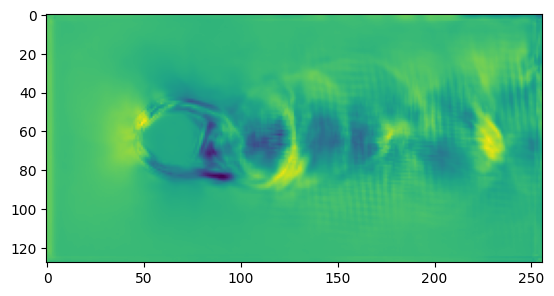

In [29]:
plt.imshow(pred_result[5,31,:,:,2])

In [45]:
np.save('ns_pred_parcv2.npy',pred_result)

In [41]:
idx = 5

/tmp/ipykernel_632067/1236665306.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, ax = plt.subplots(1,4, figsize = (15,55))


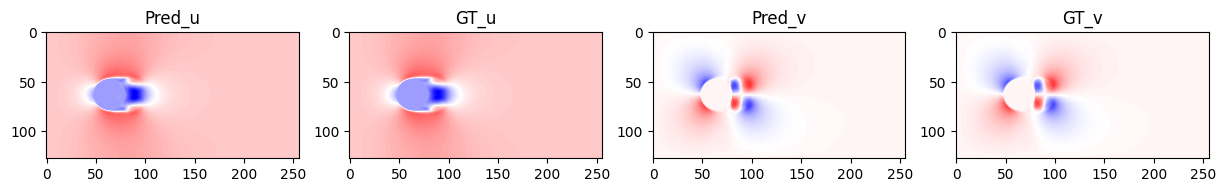

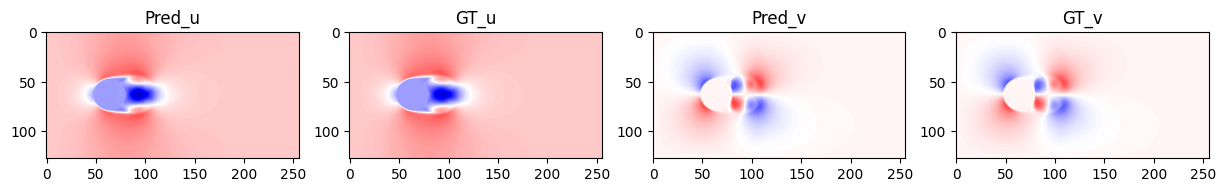

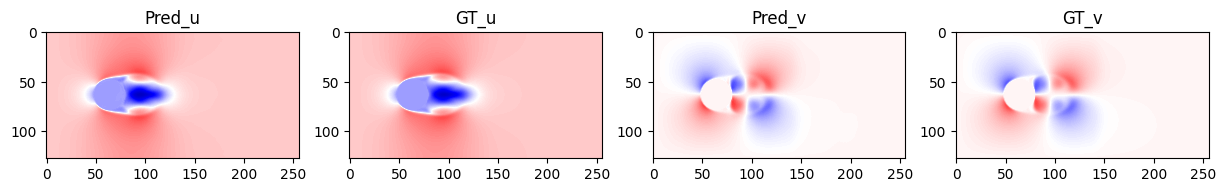

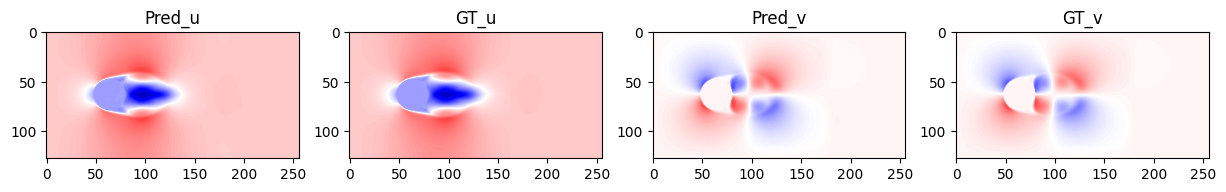

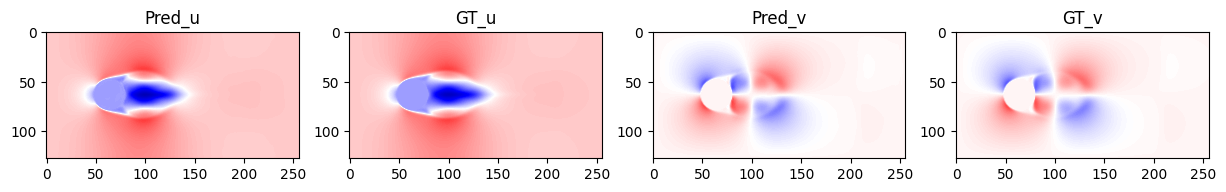

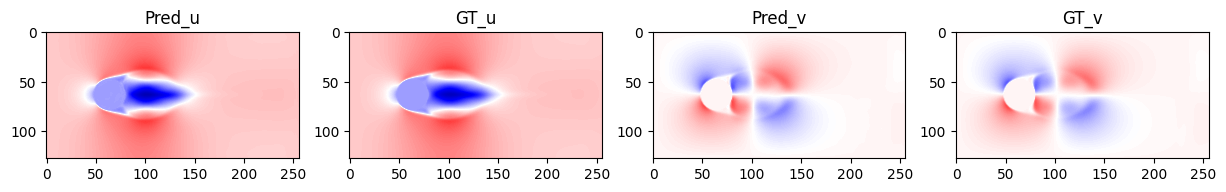

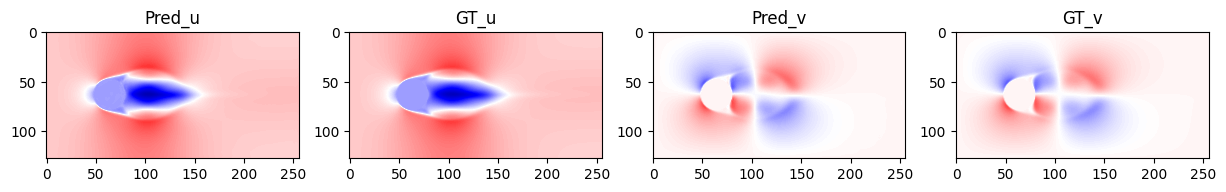

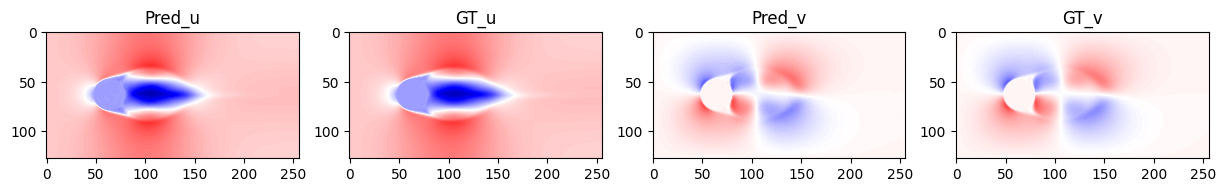

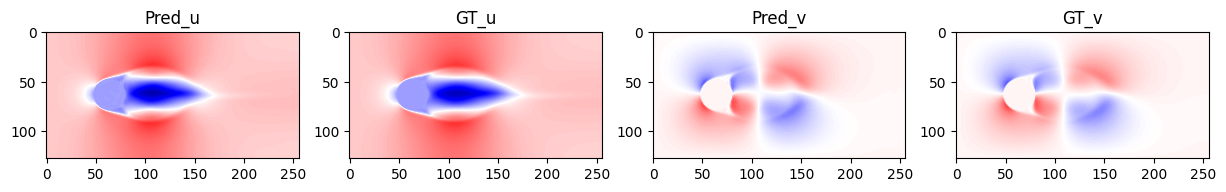

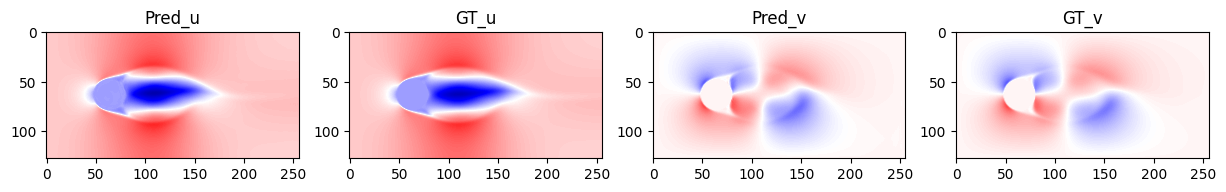

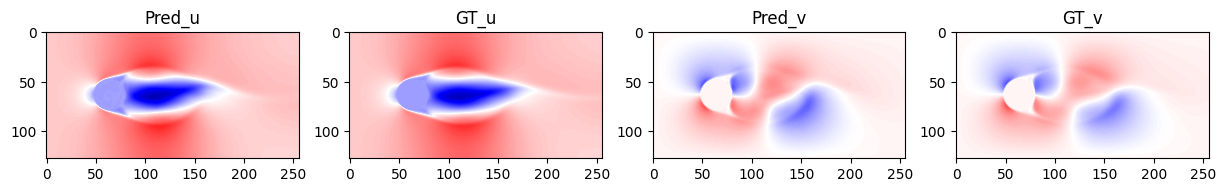

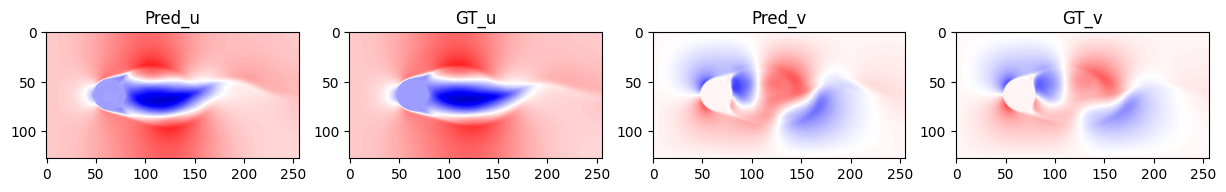

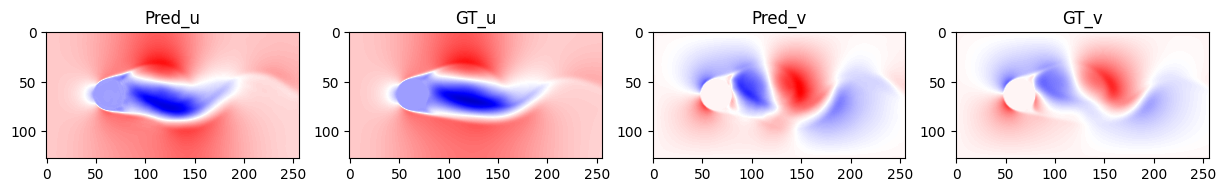

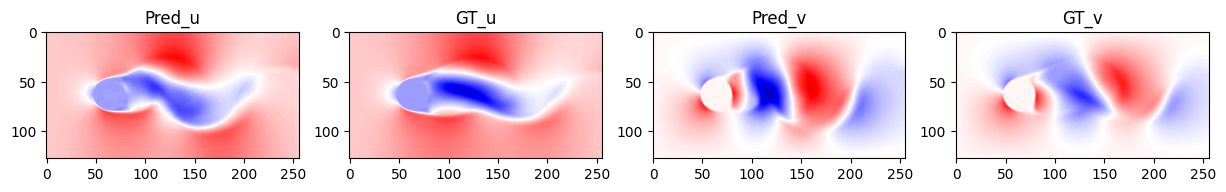

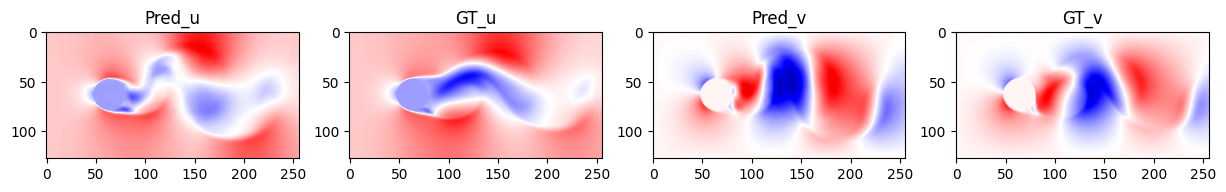

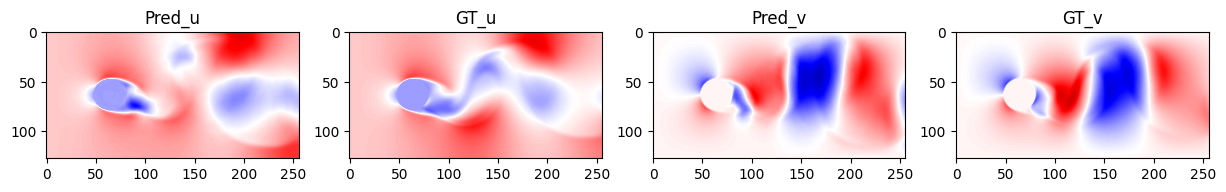

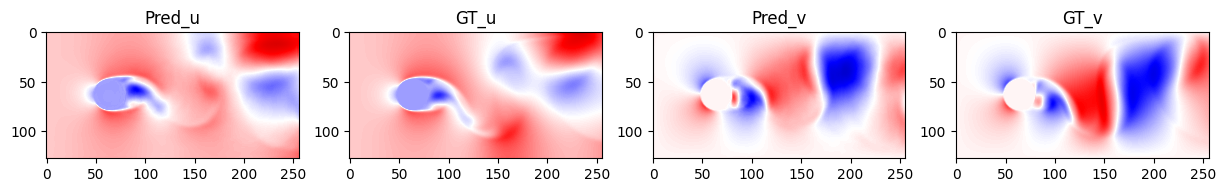

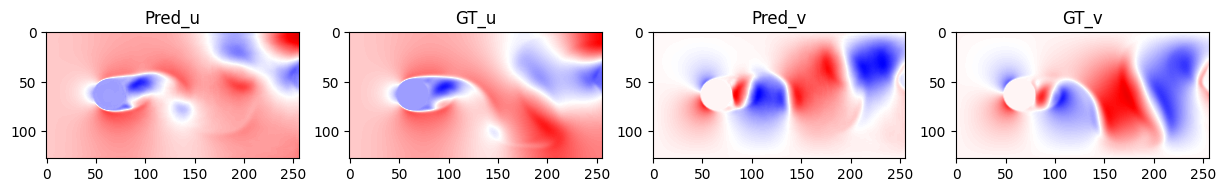

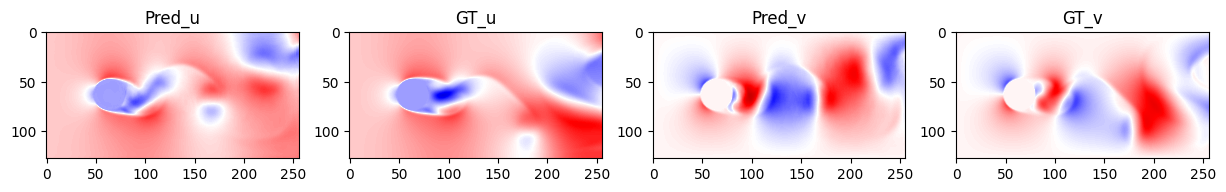

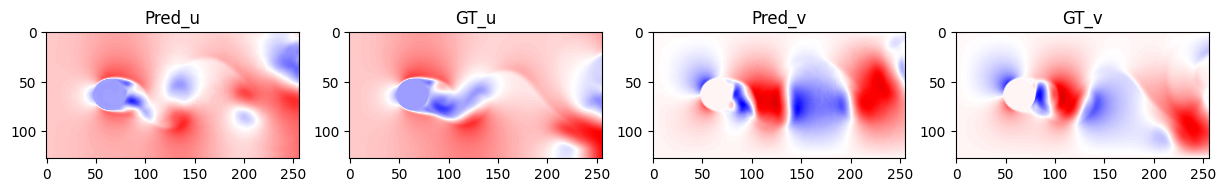

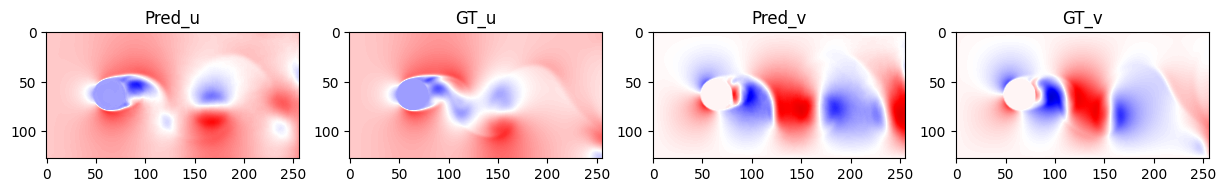

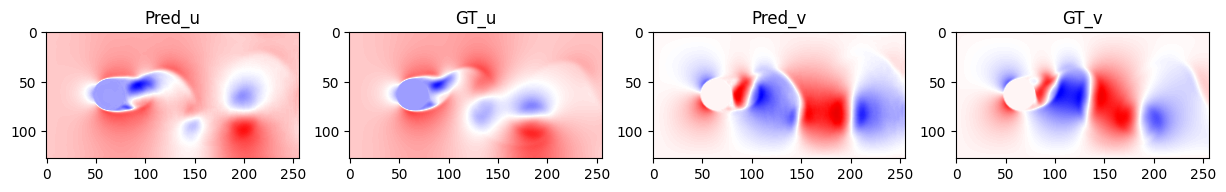

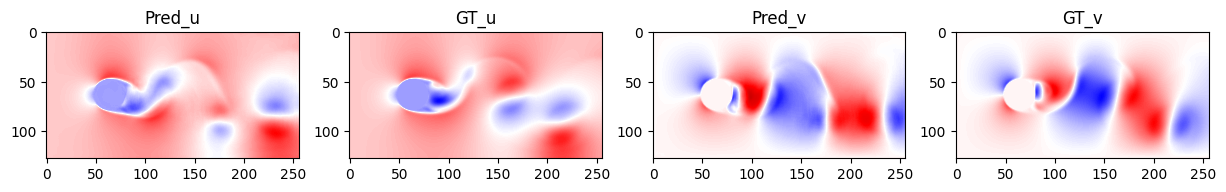

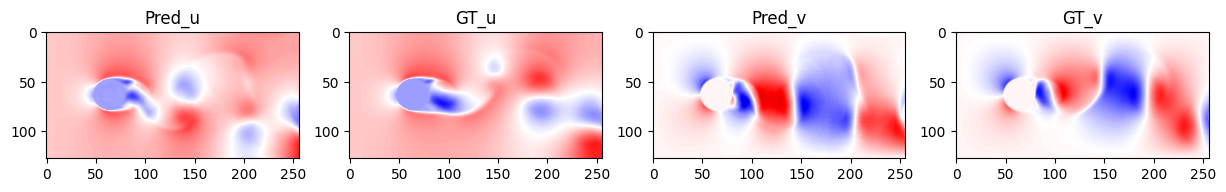

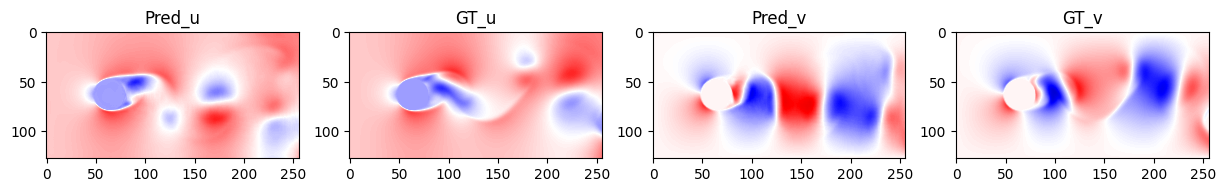

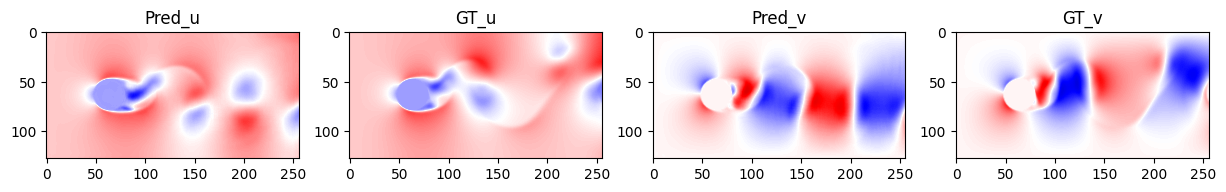

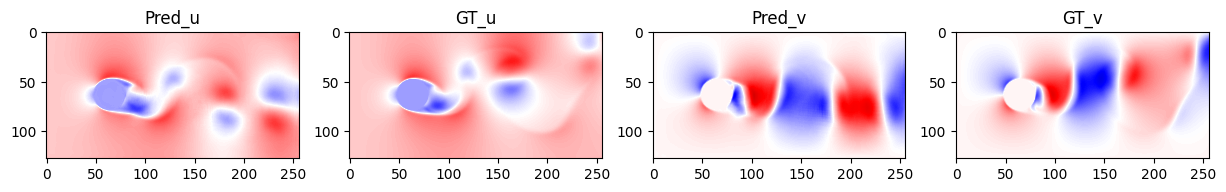

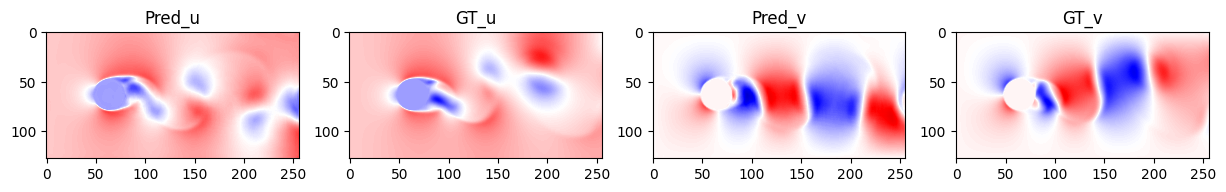

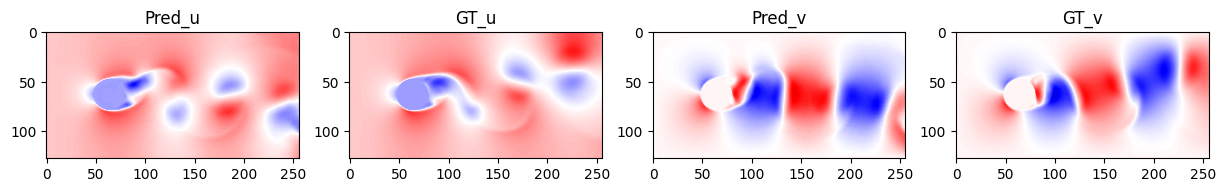

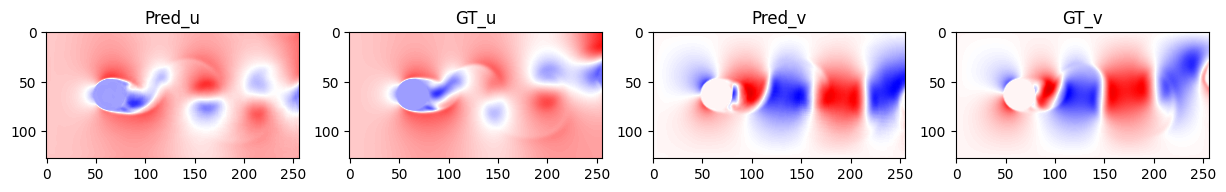

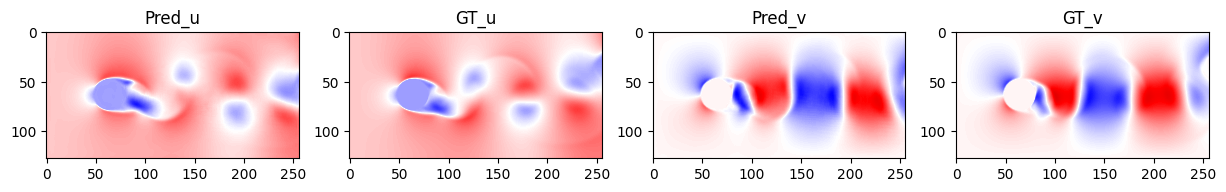

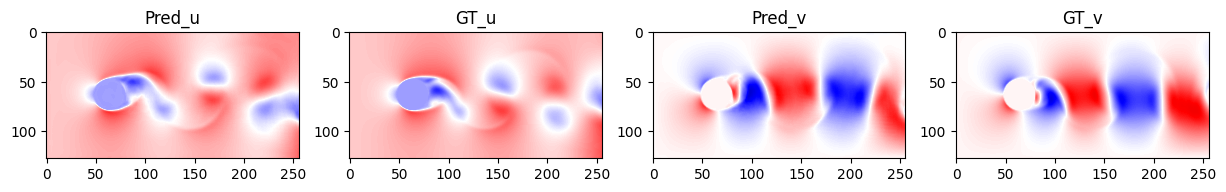

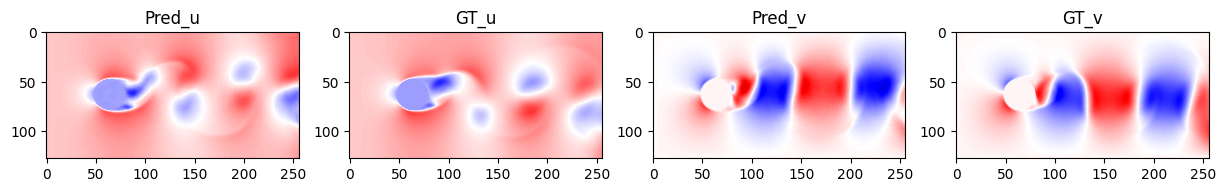

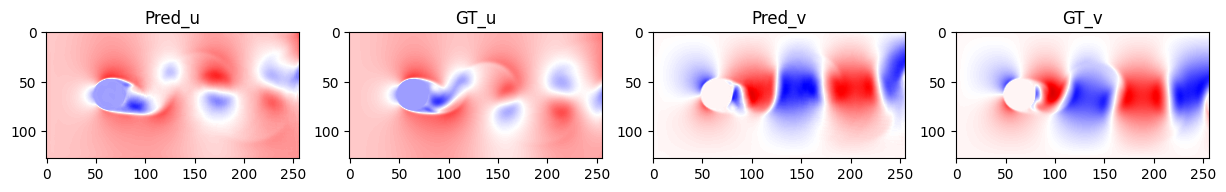

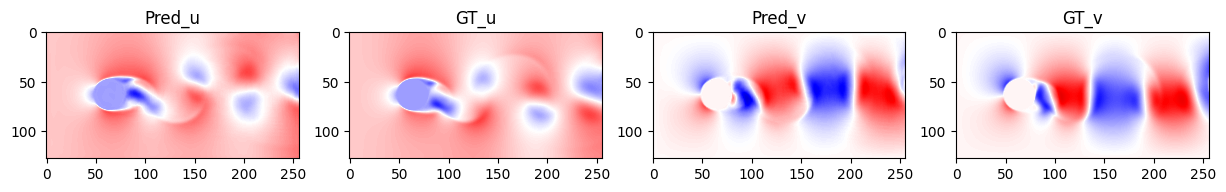

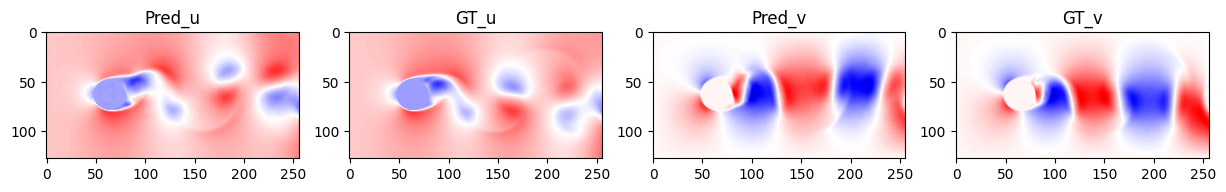

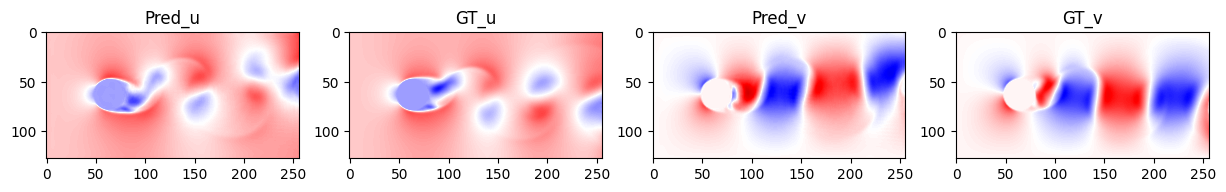

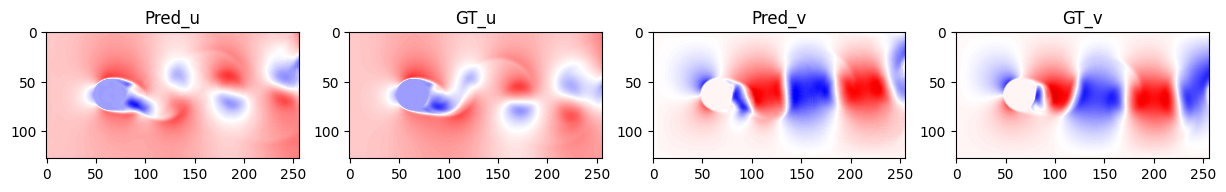

In [46]:
for i in range(38):
#     if i % 6 == 0:
        _, ax = plt.subplots(1,4, figsize = (15,55))
        ax[0].imshow(res[i][:,:,0], cmap = 'seismic', vmin = 0, vmax = 1)
        ax[0].title.set_text('Pred_u')

        ax[1].imshow(test_seq[idx,:,:,(i+1)*3], cmap = 'seismic',vmin = 0, vmax = 1)
        ax[1].title.set_text('GT_u')

        ax[2].imshow(res[i][:,:,1], cmap = 'seismic', vmin = 0, vmax = 1)
        ax[2].title.set_text('Pred_v')

        ax[3].imshow(test_seq[idx,:,:,(i+1)*3+1], cmap = 'seismic', vmin = 0, vmax = 1)
        ax[3].title.set_text('GT_v')

#         ax[4].imshow(res[i][0,:,:,2],vmin = 0.65, vmax = 0.75)
#         ax[4].title.set_text('Pred_p')

#         ax[5].imshow(test_seq[idx,:,:,(i+1)*3+2],vmin = 0.65, vmax = 0.75)
#         ax[5].title.set_text('GT_p')

In [37]:
vel_seq_norm_test.shape

(40, 128, 128, 300)

In [45]:
print(vel_seq_norm[0][0,:,:,2])
plt.colorbar()


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

<Figure size 640x480 with 0 Axes>

In [34]:
R = np.mean(vel_seq_norm[0][idx,:,:,2])

In [ ]:
for i in range(8000, 8100, 1):
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(np.squeeze(vel_seq_norm[0][i,:,:,0]),vmin = 0, vmax =0.9)
    ax[1].imshow(np.squeeze(res[i-idx][:,:,:,0]),vmin = 0, vmax =0.9)
#     ax[2].imshow(np.squeeze(np.abs(res[i][:,:,:,0]-vel_seq_norm_whole_test[idx,:,:,i*2])),vmin = 0, vmax =1)
    plt.show()

In [3]:
# Measure PDE loss


## Load model

In [74]:
tf.keras.backend.clear_session()
parc_rk = model.PARCv2(n_state_var = 3, n_time_step = 15, step_size= 1/15, solver = "rk4", mode= "integrator_training")
parc_rk.compile()
parc_rk.differentiator.load_weights('./pretrained_weights/parc2_diff_rk4.h5')
parc_rk.integrator.load_weights('./pretrained_weights/parc2_int_rk4.h5')

In [69]:
tf.keras.backend.clear_session()
parc_euler = model.PARCv2(n_state_var = 3, n_time_step = 15, step_size= 1/15, solver = "euler", mode= "integrator_training")
parc_euler.compile()
parc_euler.differentiator.load_weights('./pretrained_weights/parc2_diff_euler.h5')
parc_euler.integrator.load_weights('./pretrained_weights/parc2_int_euler.h5')

## Field evolution plot

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from scipy.ndimage import gaussian_filter
from PIL import ImageFilter, Image
from IPython.display import display

def plot_field_evolution_comparison(y_pred, y_true):
    # plot the prediction results
    x_num = np.linspace(1, 38, 38)  # discrete timesteps
    fig, ax = plt.subplots(4, 7, figsize=(39.5, 13.5))
    plt.subplots_adjust(wspace=0.06, hspace=0.07, top=0.85)
    fig.suptitle("Velocity field evolution (Re = 550)", fontsize=36)
    for i in range(7):
        ax[0][i].clear()
        ax[0][i].clear()
        ax[0][i].set_xticks([])
        ax[0][i].set_yticks([])
        im = ax[0][i].imshow(
            np.squeeze(y_true[0,:,:,(i*6+1)*3]),
            cmap="seismic",
            vmin=0,
            vmax=1,
        )
        ax[0][i].set_title(("t = " + "%.2f" % x_num[i * 6]), fontsize=32)

        ax[1][i].set_xticks([])
        ax[1][i].set_yticks([])
        ax[1][i].imshow(
            np.squeeze(y_pred[i*6][0, :, :, 0]),
            cmap="seismic",
            vmin=0,
            vmax=1)
            
        ax[2][i].set_xticks([])
        ax[2][i].set_yticks([])
        ax[2][i].imshow(
            np.squeeze(y_true[0,:,:,(i*6+1)*3+1]),
            cmap="seismic",
            vmin=0,
            vmax=1)
        
        ax[3][i].set_xticks([])
        ax[3][i].set_yticks([])
        ax[3][i].imshow(
            np.squeeze(y_pred[i*6][0, :, :, 1]),
            cmap="seismic",
            vmin=0,
            vmax=1)
        
    ax[0][0].set_ylabel("u_GT", fontsize=32)
    ax[1][0].set_ylabel("u_pred", fontsize=32)
    ax[2][0].set_ylabel("v_GT", fontsize=32)
    ax[3][0].set_ylabel("v_pred", fontsize=32)
    fig.subplots_adjust(right=0.95)
    cbar_ax = fig.add_axes([0.96, 0.125, 0.015, 0.715])
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    cbar = fig.colorbar(
        mpl.cm.ScalarMappable(norm=norm, cmap="seismic"), cax=cbar_ax, ax=im
    )
#     cbar.set_label(weight="bold", fontsize=36)
    cbar.ax.tick_params(labelsize=36)
    plt.show()

In [55]:
test_seq.shape

(7, 128, 256, 117)

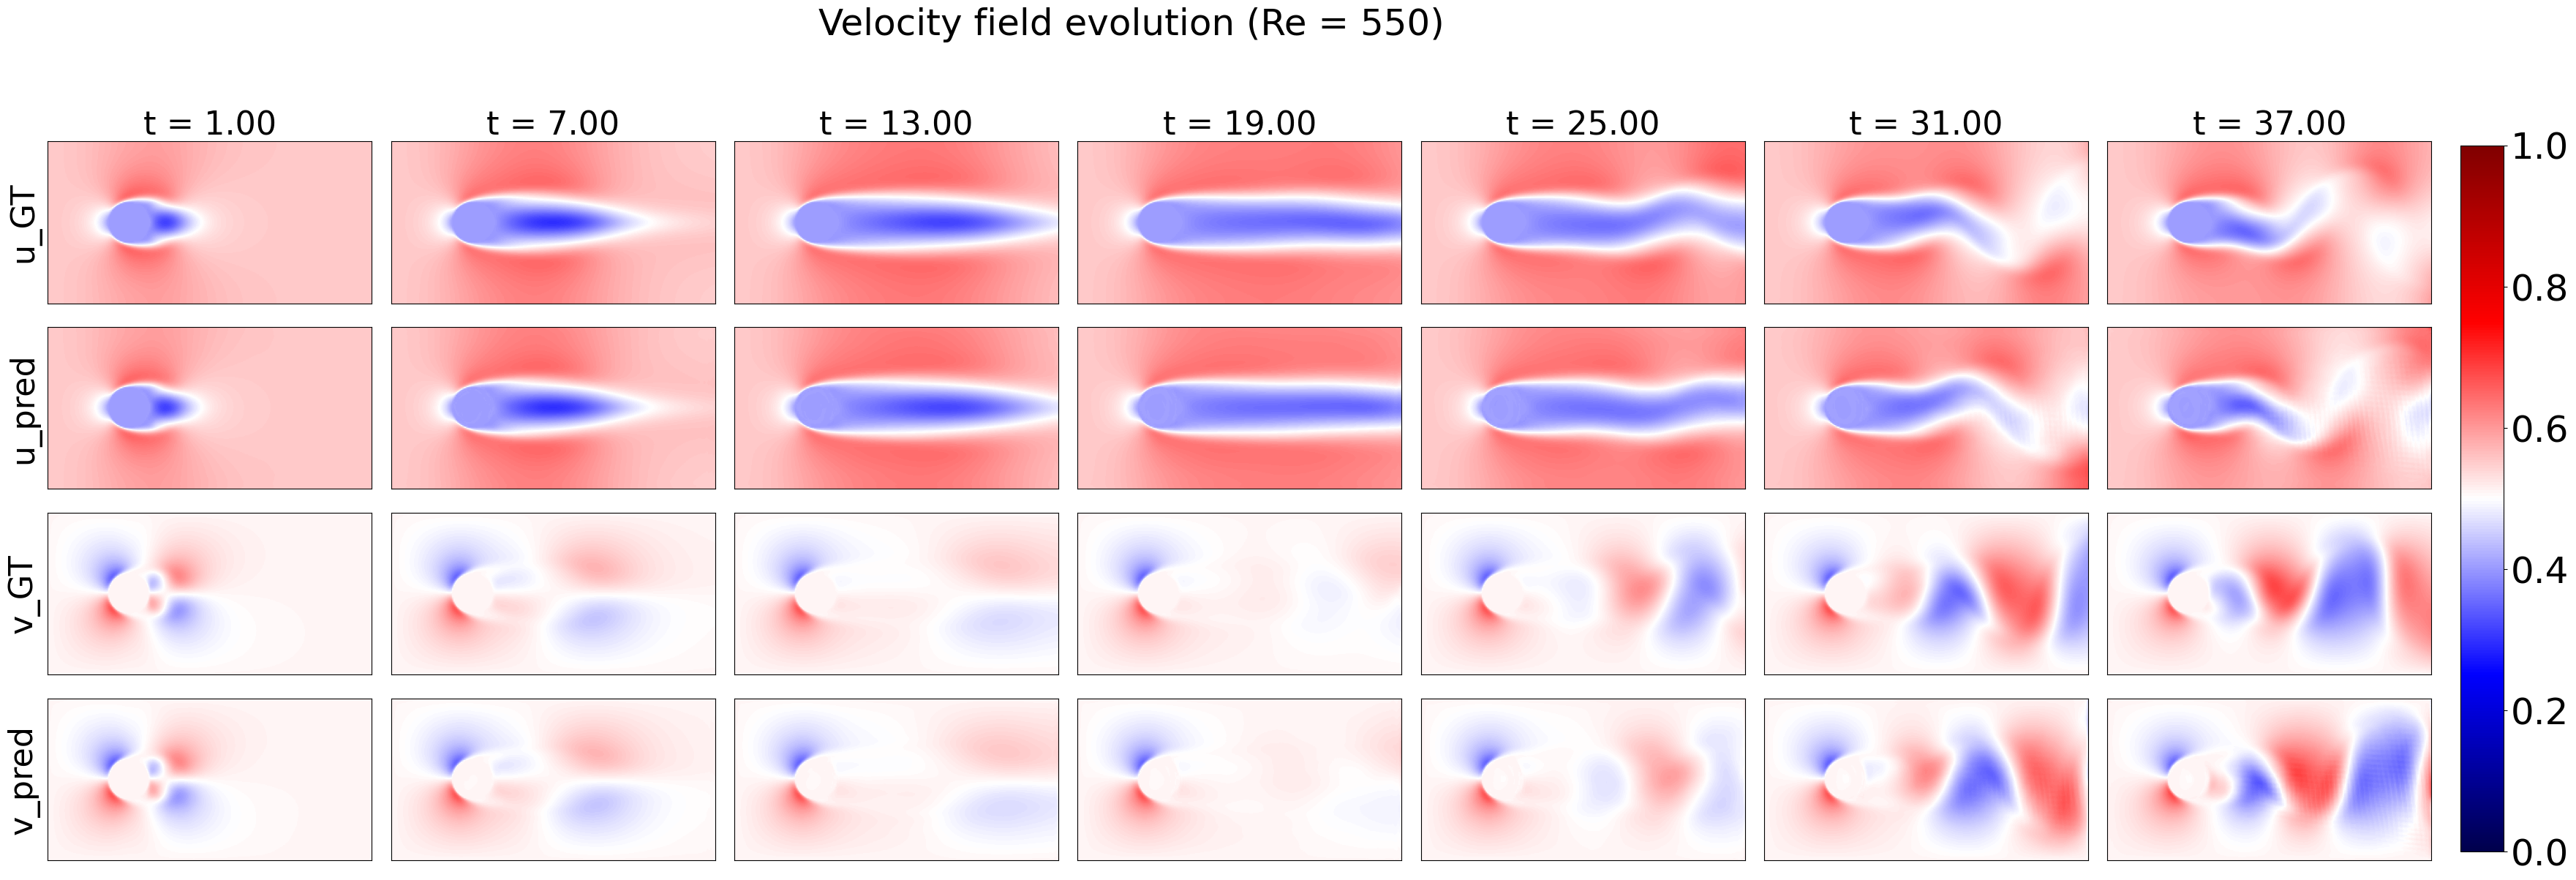

In [87]:
plot_field_evolution_comparison(res,test_seq[idx:idx+1,:,:,:])

In [106]:
parc.use_data_driven_int = True
parc.compile()
# parc.n_time_step = 15


In [94]:
# Make prediction
case_idx = 28
state_var_current = state_seq_norm_test[case_idx:case_idx+1,:,:,0:3]
velocity_current = vel_seq_norm_test[case_idx:case_idx+1,:,:,0:2]
pred_state_rk = parc_rk.predict([state_var_current,velocity_current])
pred_state_euler = parc_euler.predict([state_var_current,velocity_current])


1/1 [==============================] - 0s 283ms/step


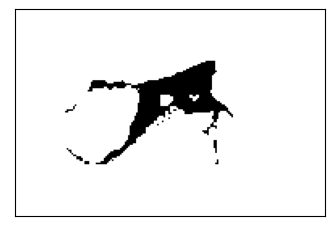

In [116]:
fig = plt.figure(figsize=(4, 6))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(np.squeeze(state_seq_norm_test[case_idx, :, :, 2]), cmap="gray", vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

### Temperature

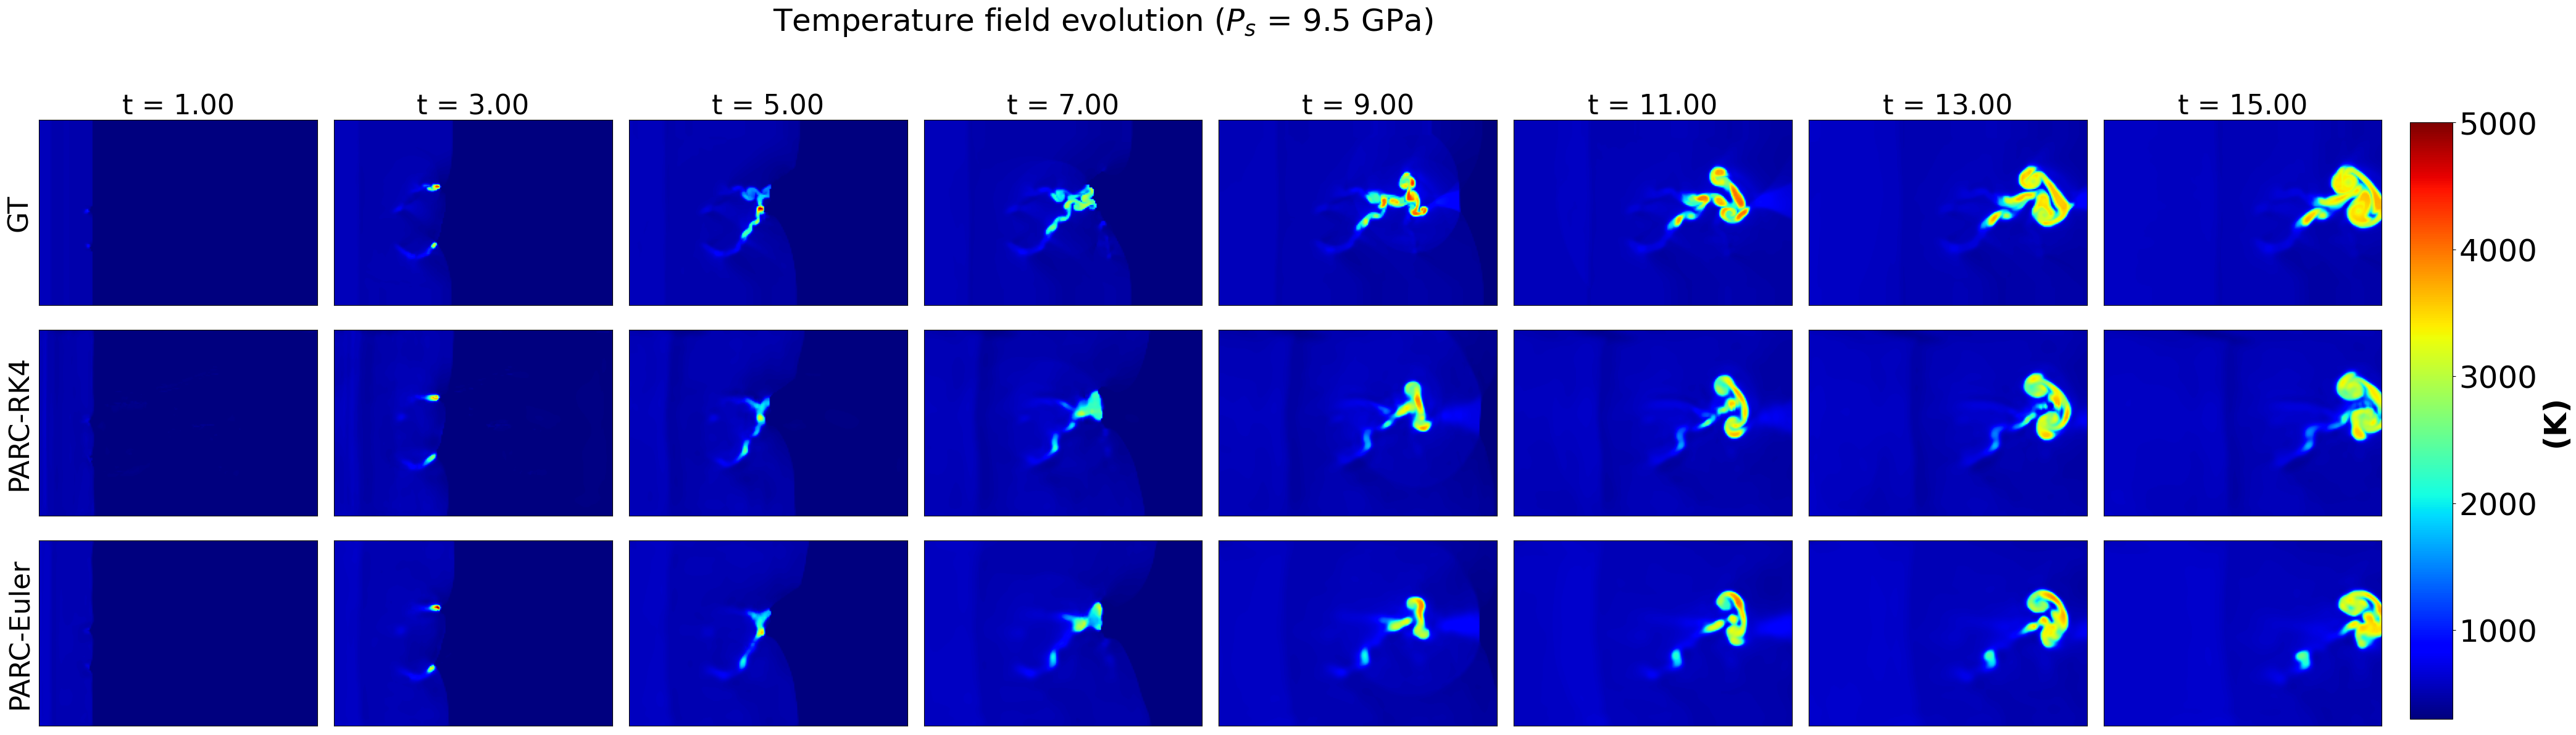

In [113]:
plot_field_evolution_comparison(pred_state_rk, pred_state_euler, state_seq_norm_test[case_idx:case_idx+1,:,:,3:], state_var_type="temperature")

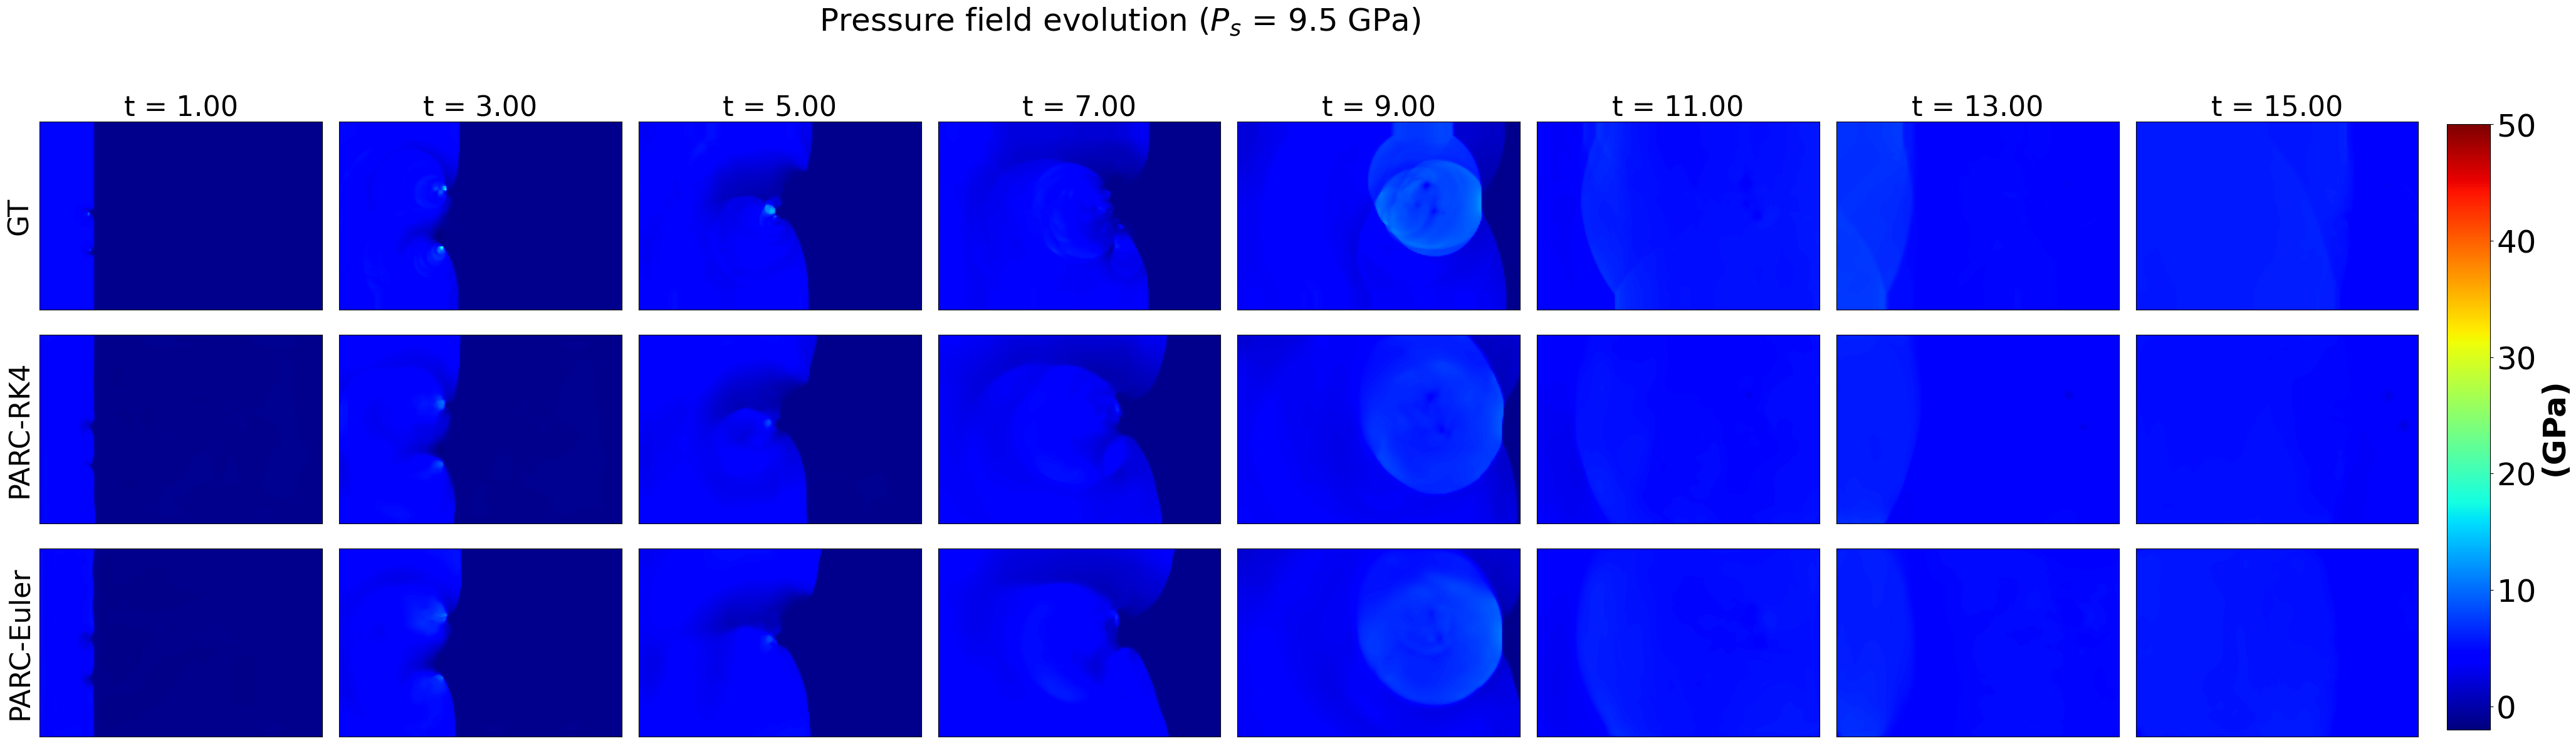

In [115]:
plot_field_evolution_comparison(pred_state_rk, pred_state_euler, state_seq_norm_test[case_idx:case_idx+1,:,:,3:], state_var_type="pressure")

### Pressure

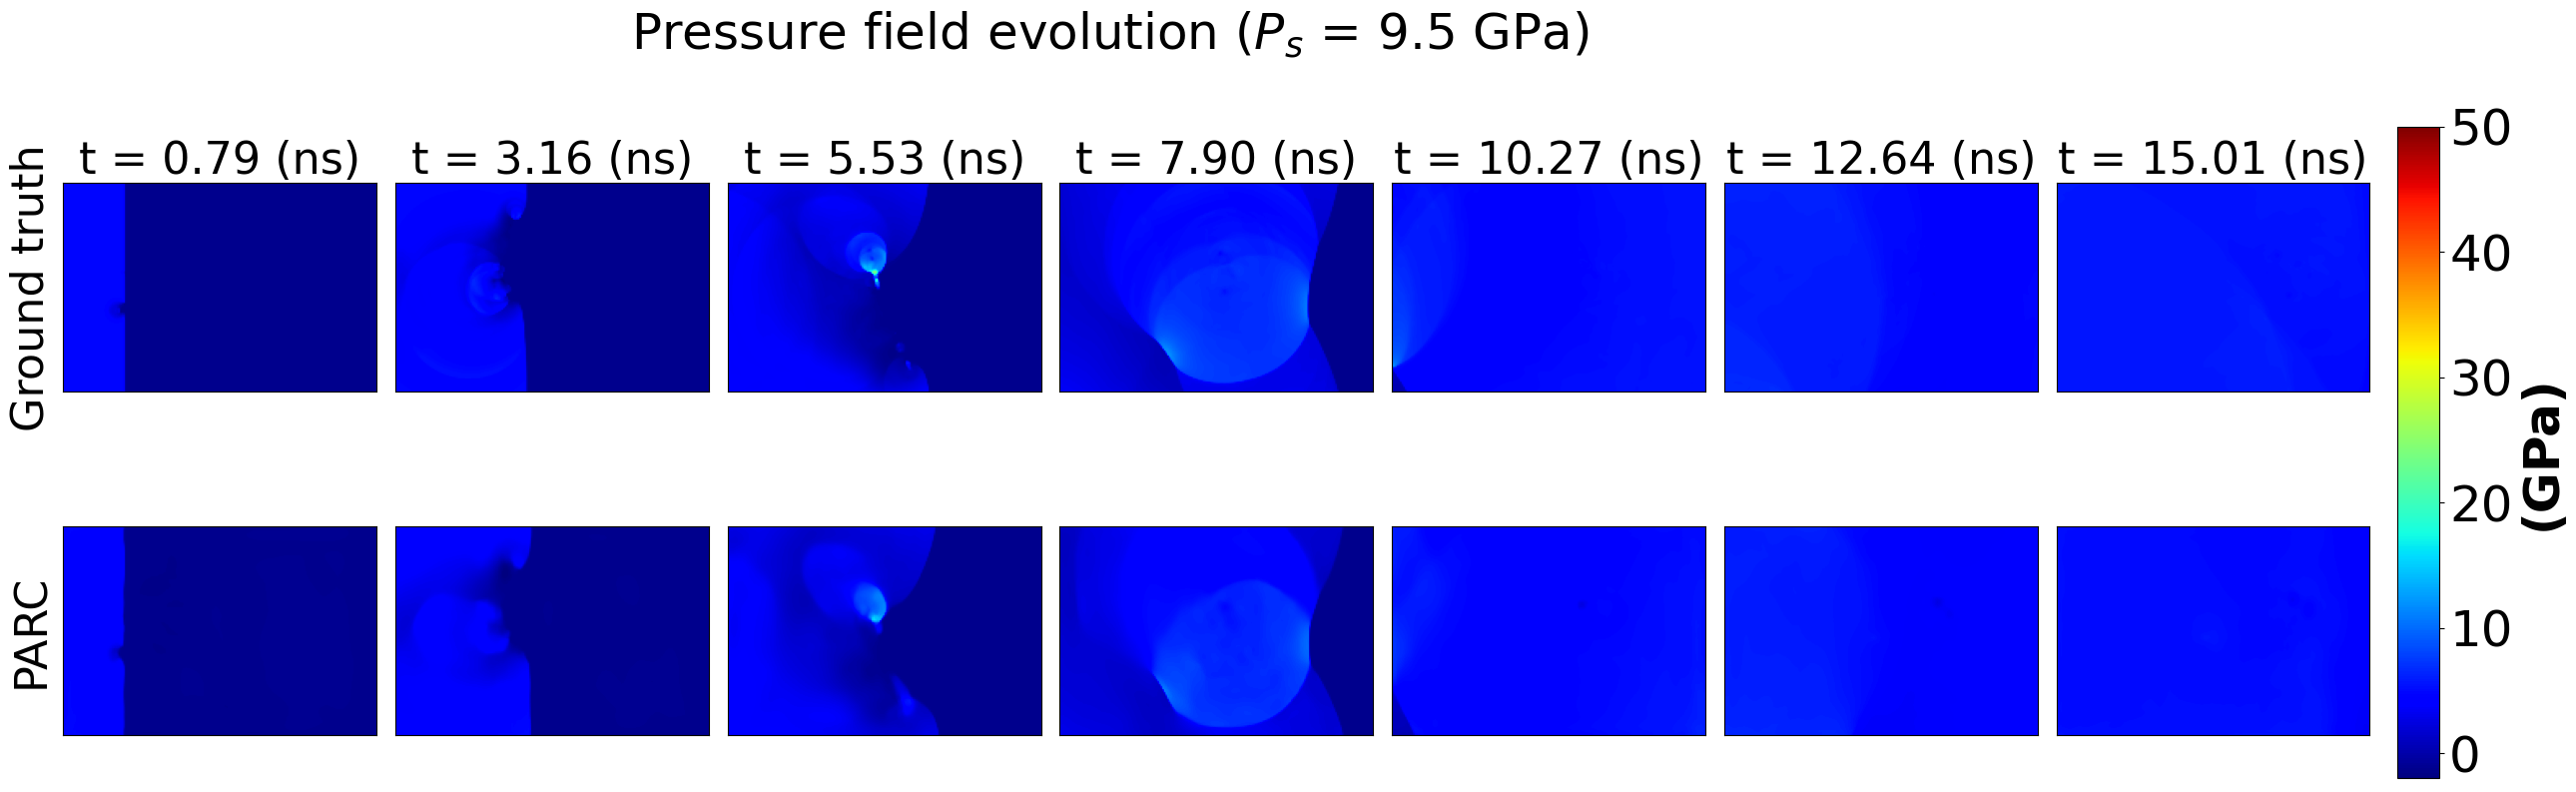

In [65]:
visualization.plot_field_evolution(pred_state, state_seq_norm_test[case_idx:case_idx+1,:,:,3:], state_var_type="pressure")

### Velocity in x direction

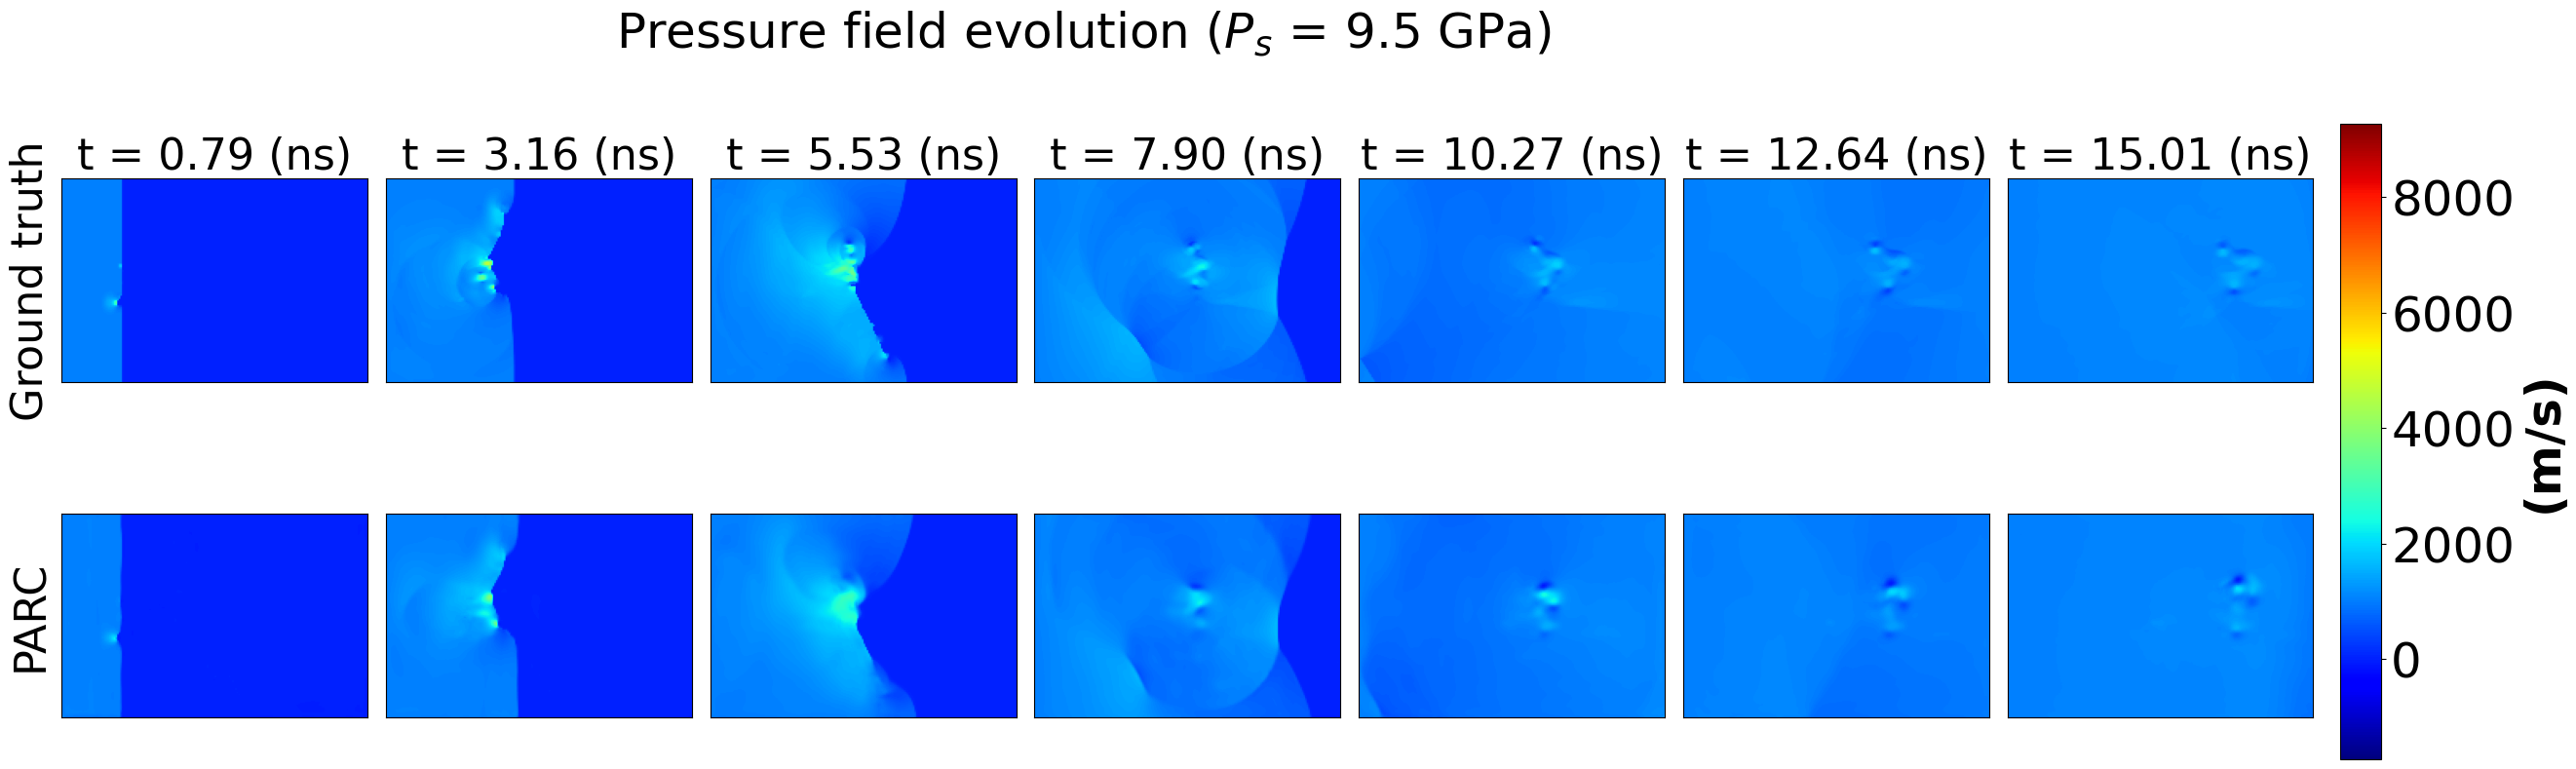

In [67]:
visualization.plot_field_evolution(pred_state, vel_seq_norm_test[case_idx:case_idx+1,:,:,2:], state_var_type="vel_x")

### Velocity in y direction

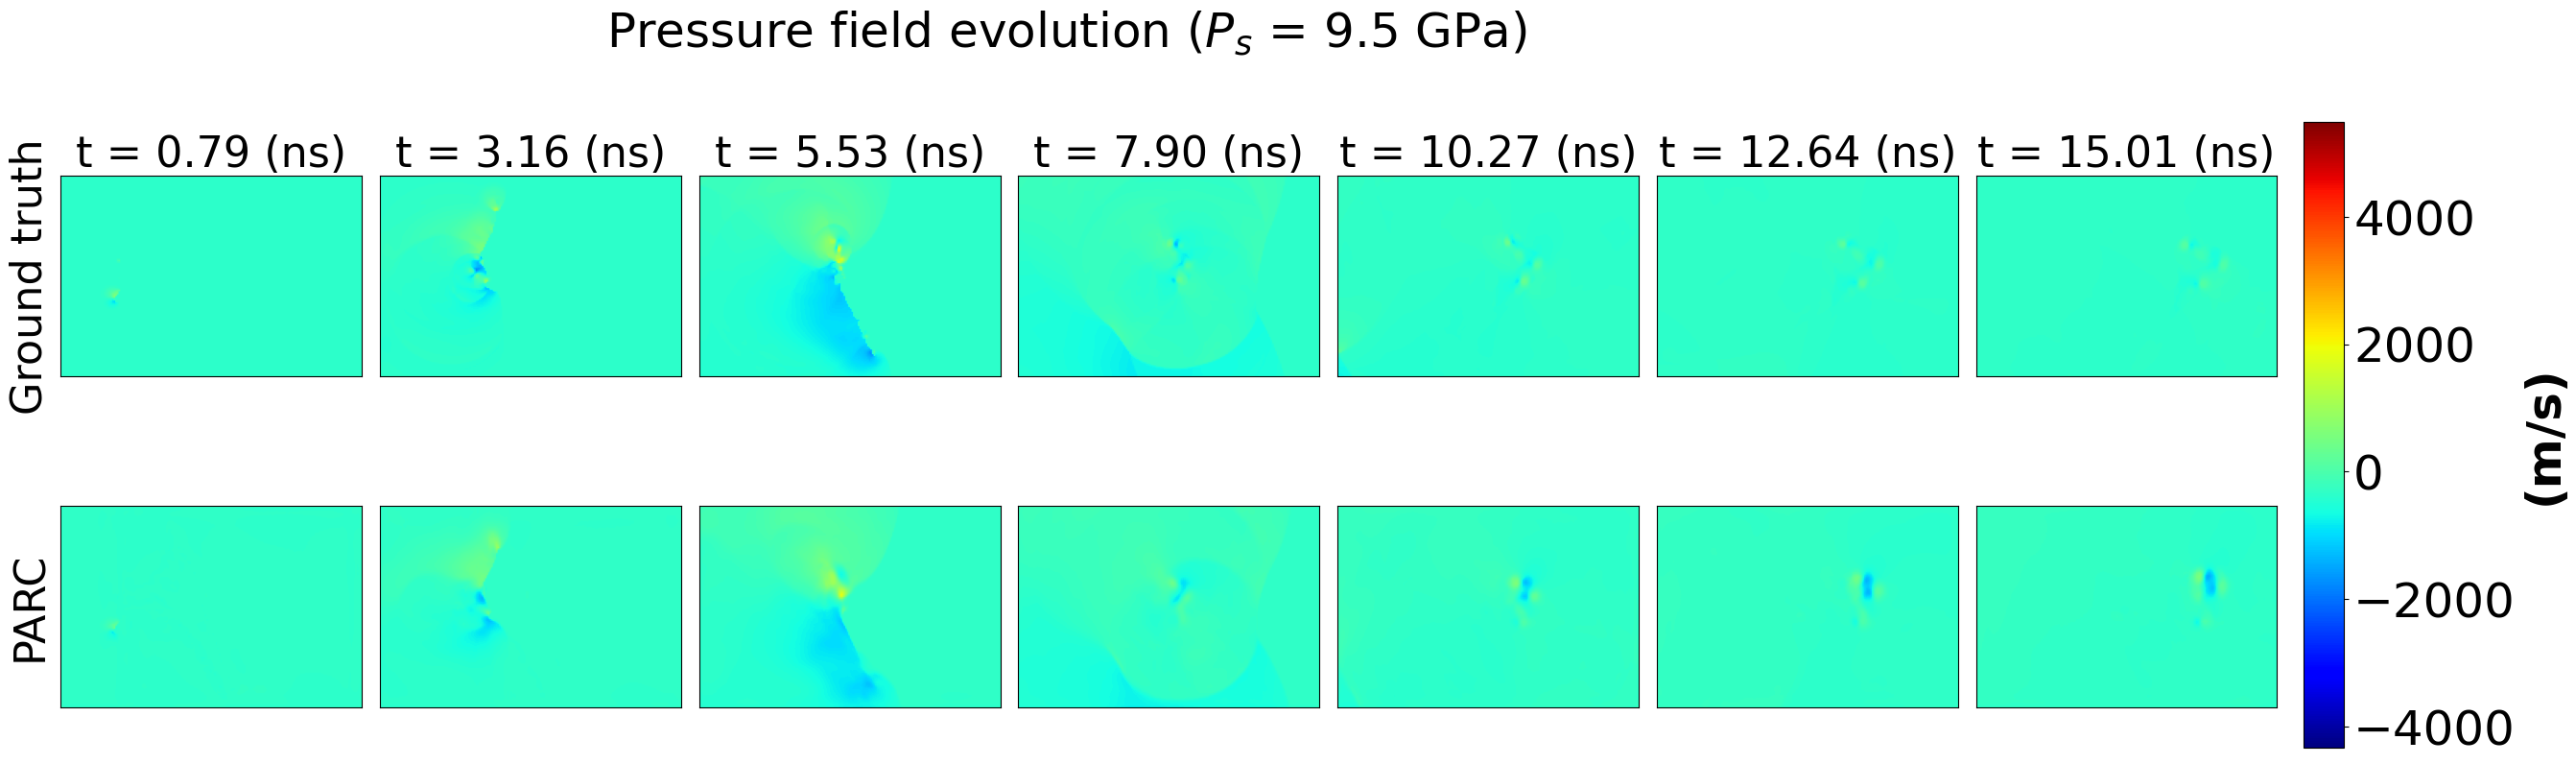

In [68]:
visualization.plot_field_evolution(pred_state, vel_seq_norm_test[case_idx:case_idx+1,:,:,2:], state_var_type="vel_y")

### Quantitative analysis

In [122]:
state_rk = []
outlier = [0,3,30,32,33, 8, 10, 19, 24]
# outlier = []
for idx in range(34):
    if idx not in outlier:
        print(idx)
        state_var_current = state_seq_norm_test[idx:idx+1,:,:,0:3]
        velocity_current = vel_seq_norm_test[idx:idx+1,:,:,0:2]
        pred_state = parc_rk.predict([state_var_current,velocity_current])
        pred_state_case = np.concatenate(pred_state, axis = -1)
        print(pred_state_case.shape)
        state_rk.append(pred_state_case)
state_rk = np.concatenate(state_rk, axis = 0)
print(state_rk.shape)       

1
1/1 [==============================] - 1s 768ms/step
(1, 128, 192, 75)
2
1/1 [==============================] - 1s 731ms/step
(1, 128, 192, 75)
4
1/1 [==============================] - 1s 731ms/step
(1, 128, 192, 75)
5
1/1 [==============================] - 1s 730ms/step
(1, 128, 192, 75)
6
1/1 [==============================] - 1s 725ms/step
(1, 128, 192, 75)
7
1/1 [==============================] - 1s 722ms/step
(1, 128, 192, 75)
9
1/1 [==============================] - 1s 728ms/step
(1, 128, 192, 75)
11
1/1 [==============================] - 1s 730ms/step
(1, 128, 192, 75)
12
1/1 [==============================] - 1s 731ms/step
(1, 128, 192, 75)
13
1/1 [==============================] - 1s 727ms/step
(1, 128, 192, 75)
14
1/1 [==============================] - 1s 727ms/step
(1, 128, 192, 75)
15
1/1 [==============================] - 1s 730ms/step
(1, 128, 192, 75)
16
1/1 [==============================] - 1s 730ms/step
(1, 128, 192, 75)
17
1/1 [==============================] - 1s 

In [123]:
state_euler = []
outlier = [0,3,30,32,33, 8, 10, 19, 24]
# outlier = []
for idx in range(34):
    if idx not in outlier:
        print(idx)
        state_var_current = state_seq_norm_test[idx:idx+1,:,:,0:3]
        velocity_current = vel_seq_norm_test[idx:idx+1,:,:,0:2]
        pred_state = parc_euler.predict([state_var_current,velocity_current])
        pred_state_case = np.concatenate(pred_state, axis = -1)
        print(pred_state_case.shape)
        state_euler.append(pred_state_case)
state_euler = np.concatenate(state_euler, axis = 0)
print(state_euler.shape)       

1
1/1 [==============================] - 0s 284ms/step
(1, 128, 192, 75)
2
1/1 [==============================] - 0s 279ms/step
(1, 128, 192, 75)
4
1/1 [==============================] - 0s 277ms/step
(1, 128, 192, 75)
5
1/1 [==============================] - 0s 279ms/step
(1, 128, 192, 75)
6
1/1 [==============================] - 0s 280ms/step
(1, 128, 192, 75)
7
1/1 [==============================] - 0s 280ms/step
(1, 128, 192, 75)
9
1/1 [==============================] - 0s 278ms/step
(1, 128, 192, 75)
11
1/1 [==============================] - 0s 278ms/step
(1, 128, 192, 75)
12
1/1 [==============================] - 0s 278ms/step
(1, 128, 192, 75)
13
1/1 [==============================] - 0s 280ms/step
(1, 128, 192, 75)
14
1/1 [==============================] - 0s 279ms/step
(1, 128, 192, 75)
15
1/1 [==============================] - 0s 279ms/step
(1, 128, 192, 75)
16
1/1 [==============================] - 0s 280ms/step
(1, 128, 192, 75)
17
1/1 [==============================] - 0s 

In [124]:
## Preprocess temperature data
# Get temperature field evolution
Temp_gt = state_seq_norm_test[:,:,:,3::3]    # Ground truth temperature field evolution
# Temp_gt = np.clip(Temp_gt,0,1)
Temp_pred_parc_rk = state_rk[:,:,:,0::5]   # PARC prediction temperature field evolution
Temp_pred_parc_euler = state_euler[:,:,:,0::5]   # PARC prediction temperature field evolution

# # Denormalize temperature field evolution
Temp_gt = misc.scale_temperature(temperatures = Temp_gt, start_ts = 0, max_temp = 5000, min_temp = 300)
Temp_pred_parc_rk = misc.scale_temperature(temperatures = Temp_pred_parc_rk, start_ts = 0, max_temp = 5000, min_temp = 300)
Temp_pred_parc_euler = misc.scale_temperature(temperatures = Temp_pred_parc_euler, start_ts = 0, max_temp = 5000, min_temp = 300)

# Compute sensitivity of ground truth data
gt_hs_temp, gt_hs_area = metrics.calculate_hotspot_metric(Temp_gt[:,:,:,0:], cases_range = (0,25), n_timesteps = 15)
gt_rate_hs_temp,gt_rate_hs_area = metrics.calculate_hotspot_metric_rate_of_change(Temp_gt[:,:,:,0:], cases_range = (0,25), n_timesteps = 15)

# Compute sensitivity of PARC prediction
parc_hs_temp_rk, parc_hs_area_rk = metrics.calculate_hotspot_metric(Temp_pred_parc_rk[:,:,:,0:], cases_range = (0,25), n_timesteps =15)
parc_rate_hs_temp_rk, parc_rate_hs_area_rk = metrics.calculate_hotspot_metric_rate_of_change(Temp_pred_parc_rk[:,:,:,0:], cases_range = (0,25), n_timesteps = 15)

# Compute sensitivity of PARC prediction
parc_hs_temp_euler, parc_hs_area_euler = metrics.calculate_hotspot_metric(Temp_pred_parc_euler[:,:,:,0:], cases_range = (0,25), n_timesteps =15)
parc_rate_hs_temp_euler, parc_rate_hs_area_euler = metrics.calculate_hotspot_metric_rate_of_change(Temp_pred_parc_euler[:,:,:,0:], cases_range = (0,25), n_timesteps = 15)

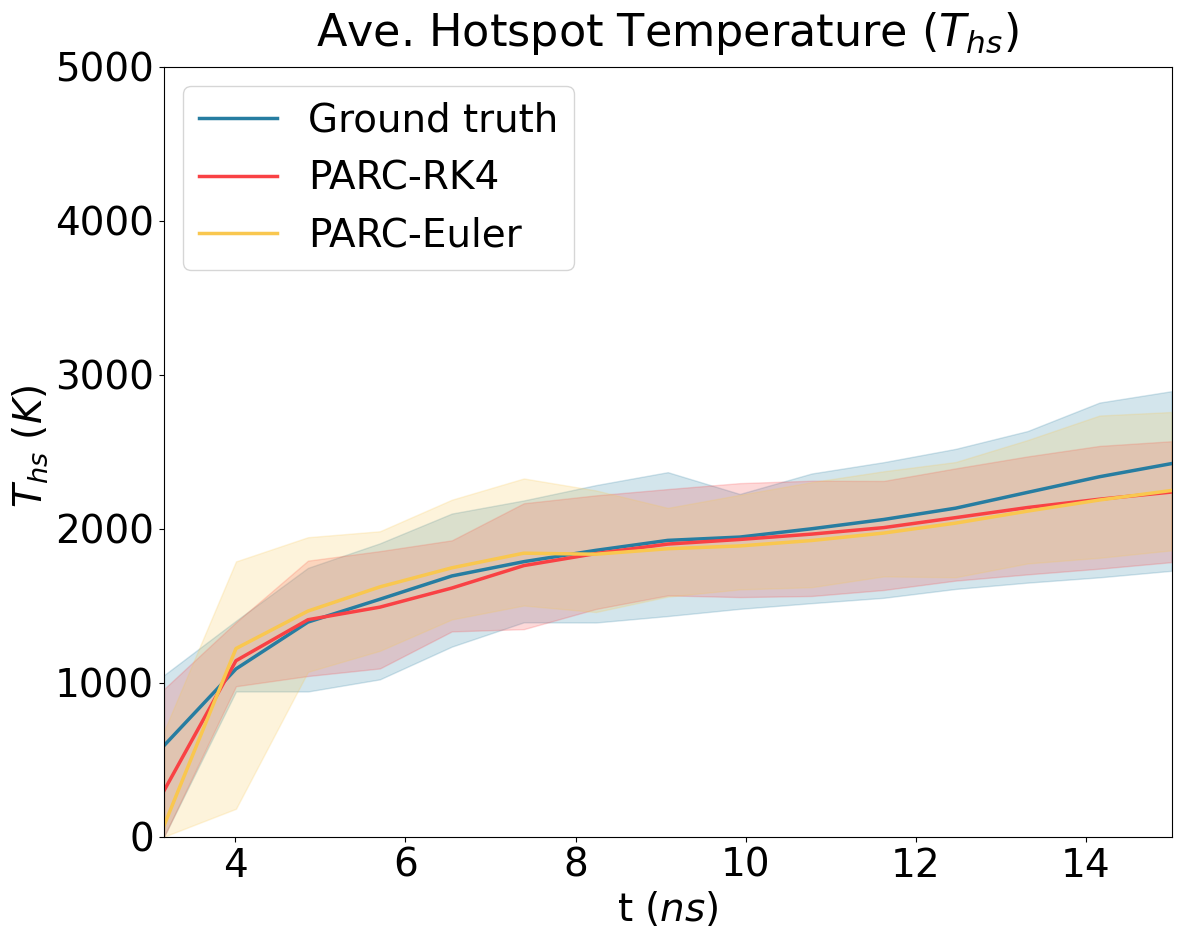

In [158]:
plot_sensitivity(y_true=gt_hs_temp, y_pred_rk=parc_hs_temp_rk, y_pred_euler = parc_hs_temp_euler,  metric='hs_temp',ts=15)

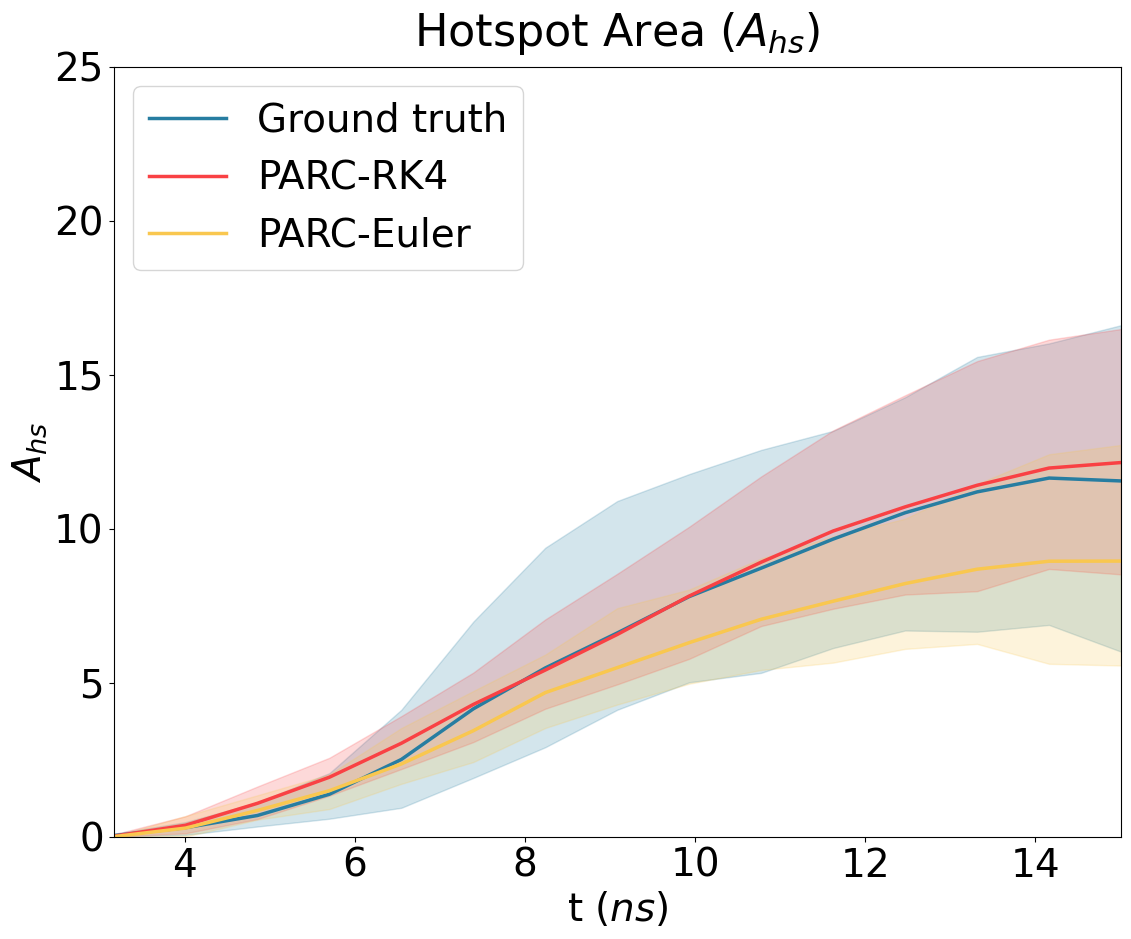

In [154]:
plot_sensitivity(y_true=gt_hs_area, y_pred_rk=parc_hs_area_rk, y_pred_euler = parc_hs_area_euler, metric='hs_area',ts=15)

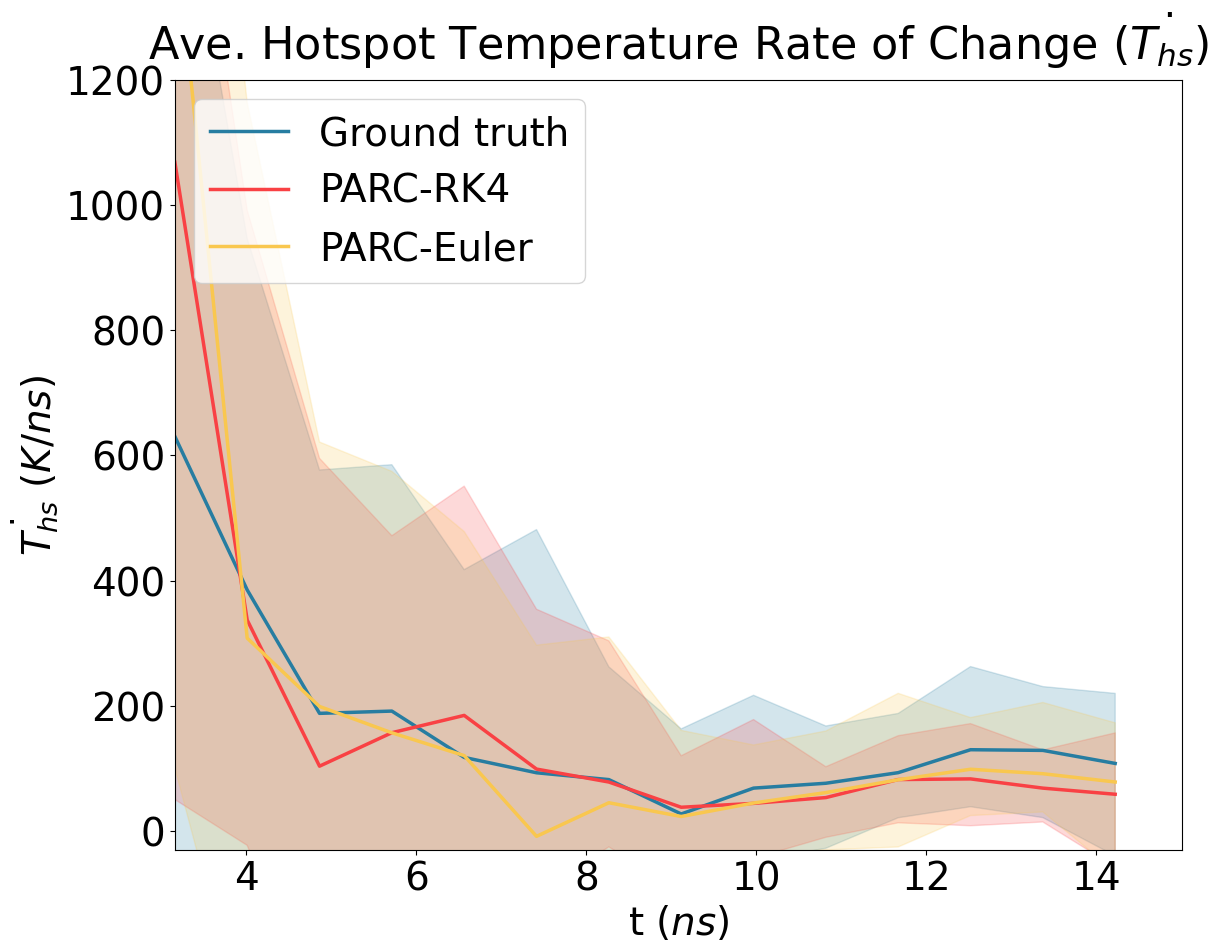

In [155]:
plot_sensitivity(y_true=gt_rate_hs_temp, y_pred_rk=parc_rate_hs_temp_rk, y_pred_euler = parc_rate_hs_temp_euler, metric='rate_hs_temp',ts=15)

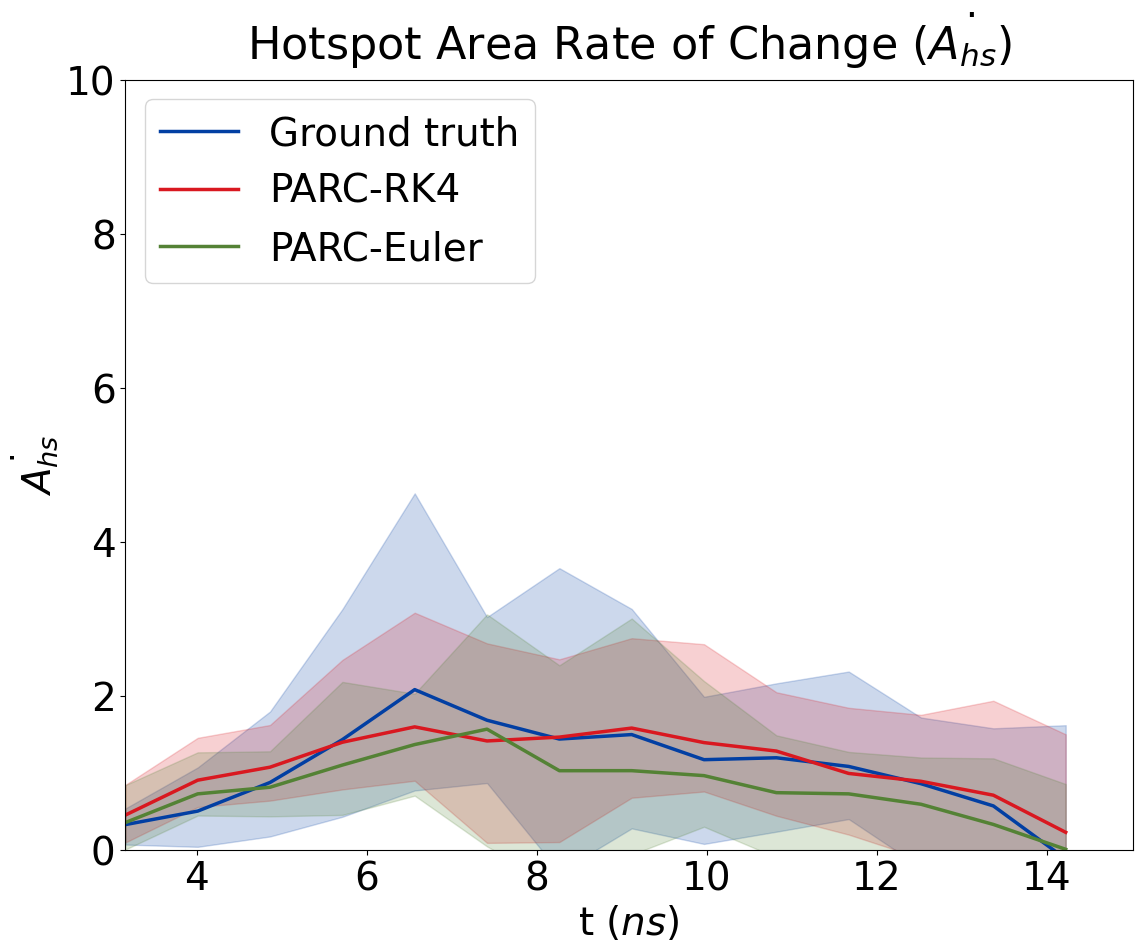

In [135]:
plot_sensitivity(y_true=gt_rate_hs_area, y_pred_rk=parc_rate_hs_area_rk, y_pred_euler = parc_rate_hs_area_euler, metric='rate_hs_area',ts=15)

## Physics-informed loss

In [ ]:
# define the high-order finite difference kernels
lapl_op = [[[[    0,   0, -1/12,   0,     0],
             [    0,   0,   4/3,   0,     0],
             [-1/12, 4/3,    -5, 4/3, -1/12],
             [    0,   0,   4/3,   0,     0],
             [    0,   0, -1/12,   0,     0]]]]

partial_y = [[[[0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0],
               [1/12, -8/12, 0, 8/12, -1/12],
               [0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0]]]]

partial_x = [[[[0, 0, 1/12, 0, 0],
               [0, 0, -8/12, 0, 0],
               [0, 0, 0, 0, 0],
               [0, 0, 8/12, 0, 0],
               [0, 0, -1/12, 0, 0]]]]

In [ ]:
class loss_generator(nn.Module):
    ''' Loss generator for physics loss '''

    def __init__(self, dt = (2.0/100), dx = (6/128)):
        ''' Construct the derivatives, X = Width, Y = Height '''
       
        super(loss_generator, self).__init__()

        # spatial derivative operator
        self.laplace = Conv2dDerivative(
            DerFilter = lapl_op,
            resol = (dx**2),
            kernel_size = 5,
            name = 'laplace_operator').cuda()

        self.dx = Conv2dDerivative(
            DerFilter = partial_x,
            resol = (dx*1),
            kernel_size = 5,
            name = 'dx_operator').cuda()

        self.dy = Conv2dDerivative(
            DerFilter = partial_y,
            resol = (dx*1),
            kernel_size = 5,
            name = 'dy_operator').cuda()

        # temporal derivative operator
        self.dt = Conv1dDerivative(
            DerFilter = [[[-1, 0, 1]]],
            resol = (dt*2),
            kernel_size = 3,
            name = 'partial_t').cuda()

    def get_phy_Loss(self, output):

        # spatial derivatives
        laplace_u = self.laplace(output[1:-1, 0:1, :, :])  # [t,c,h,w]
        laplace_v = self.laplace(output[1:-1, 1:2, :, :])

        u_x = self.dx(output[1:-1, 0:1, :, :])
        u_y = self.dy(output[1:-1, 0:1, :, :])
        v_x = self.dx(output[1:-1, 1:2, :, :])
        v_y = self.dy(output[1:-1, 1:2, :, :])

        # temporal derivative - u
        u = output[:, 0:1, 2:-2, 2:-2]
        lent = u.shape[0]
        lenx = u.shape[3]
        leny = u.shape[2]
        u_conv1d = u.permute(2, 3, 1, 0)  # [height(Y), width(X), c, step]
        u_conv1d = u_conv1d.reshape(lenx*leny,1,lent)
        u_t = self.dt(u_conv1d)  # lent-2 due to no-padding
        u_t = u_t.reshape(leny, lenx, 1, lent-2)
        u_t = u_t.permute(3, 2, 0, 1)  # [step-2, c, height(Y), width(X)]

        # temporal derivative - v
        v = output[:, 1:2, 2:-2, 2:-2]
        v_conv1d = v.permute(2, 3, 1, 0)  # [height(Y), width(X), c, step]
        v_conv1d = v_conv1d.reshape(lenx*leny,1,lent)
        v_t = self.dt(v_conv1d)  # lent-2 due to no-padding
        v_t = v_t.reshape(leny, lenx, 1, lent-2)
        v_t = v_t.permute(3, 2, 0, 1)  # [step-2, c, height(Y), width(X)]

        u = output[1:-1, 0:1, 2:-2, 2:-2]  # [t, c, height(Y), width(X)]
        v = output[1:-1, 1:2, 2:-2, 2:-2]  # [t, c, height(Y), width(X)]

        assert laplace_u.shape == u_t.shape
        assert u_t.shape == v_t.shape
        assert laplace_u.shape == u.shape
        assert laplace_v.shape == v.shape

        R = 10000.0

        # 2D burgers eqn
        f_u = u_t + u * u_x + v * u_y - (1/R) * laplace_u
        f_v = v_t + u * v_x + v * v_y - (1/R) * laplace_v

        return f_u, f_v
    